In [6]:
import numpy as np
import pandas as pd

import numpy as np
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers # 케라스의 옵티마이저를 임포트


import matplotlib.pyplot as plt # 그래프 시각화
import seaborn as sns # 그래프 시각화
from sklearn.preprocessing import LabelEncoder # 라벨 인코더
from google.colab import files 
from datetime import datetime
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
train = files.upload()

Saving train.csv to train.csv


In [369]:
train = pd.read_csv('train.csv')
train.tail()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
296,422,open,jeonnam,178,20050211,214.0,nursing_hospital,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,743942102.0,187576102.0,0.0,5.943868e+08,2.776603e+09,2.769516e+09,1.797116e+09,7086391.0,1.191266e+10,1.171868e+10,119856720.0,0.0,8.715369e+09,1.520004e+09,0.0,7.195366e+09,5.930000e+09,5.973889e+09,1.406028e+09,7.068816e+09,4.057855e+08,6.755147e+09,3.768952e+09,90318167.0,2.090078e+08,196659822.0,51608640.0,-2.624151e+08,2.550562e+09,2.542336e+09,1.962693e+09,8225698.0,1.225271e+10,1.210466e+10,76856720.0,0.0,9.423771e+09,2.618201e+09,0.0,6.805570e+09,5.930000e+09,5.379502e+09,8.116416e+08,193.0,141.0,same
297,423,close,choongnam,159,20140618,NaN,hospital,6.717144e+09,8.200000e+09,0.000000e+00,0.000000e+00,186359.0,139851326.0,129697525.0,0.0,-1.622521e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,79.0,79.0,same
298,426,close,gyeongbuk,107,19830705,NaN,hospital,0.000000e+00,0.000000e+00,5.479428e+07,7.500000e+06,121022160.0,137980960.0,137980960.0,0.0,-7.175308e+07,3.867238e+09,3.867238e+09,1.132312e+09,0.0,5.569636e+09,5.419756e+09,67957340.0,0.0,6.249466e+09,2.050342e+09,0.0,4.199124e+09,2.498749e+09,3.187408e+09,0.000000e+00,3.132198e+09,2.971193e+09,3.529793e+08,1.479400e+08,173212032.0,1.330644e+08,107972617.0,0.0,-1.518272e+08,4.074622e+09,4.069797e+09,1.132312e+09,4825310.0,5.554636e+09,5.419756e+09,52957340.0,0.0,6.370097e+09,2.170973e+09,0.0,4.199124e+09,2.498749e+09,3.259161e+09,0.000000e+00,NaN,NaN,NaN
299,427,close,gyeonggi,169,20070101,180.0,nursing_hospital,2.116892e+09,2.681748e+08,3.286245e+09,2.231944e+09,123665065.0,536691924.0,514368798.0,0.0,-1.850554e+09,4.929370e+09,4.910840e+09,2.834734e+07,18529330.0,1.196624e+10,4.441451e+09,0.0,73742310.0,5.804268e+08,7.507060e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.096872e+09,4.861985e+08,4.750651e+09,2.896997e+09,10545075.0,1.600243e+09,746156653.0,0.0,-2.729675e+09,5.896047e+09,5.840526e+09,2.526034e+07,55521367.0,1.197633e+10,4.441451e+09,0.0,65242310.0,6.392336e+08,6.400000e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,100.0,NaN,NaN
300,428,open,seoul,79,20011017,NaN,traditional_hospital,1.340971e+09,8.108450e+08,5.043409e+08,1.318978e+08,2264007.0,73558495.0,73558495.0,0.0,-4.550929e+07,6.624176e+08,6.197801e+08,1.545963e+07,42637474.0,1.024680e+10,1.011968e+10,86930500.0,0.0,5.418547e+09,3.187619e+09,0.0,2.230928e+09,2.190000e+09,5.490668e+09,6.269440e+09,1.499012e+09,8.328015e+08,5.254614e+08,1.333380e+08,4301929.0,9.439391e+07,94355280.0,0.0,5.065703e+07,4.969613e+08,4.526867e+08,1.545534e+07,44274527.0,1.038822e+10,1.026110e+10,86930500.0,0.0,5.349000e+09,3.123072e+09,0.0,2.225928e+09,2.190000e+09,5.536178e+09,6.269440e+09,15.0,15.0,same


In [9]:
test = files.upload()

Saving test.csv to test.csv


In [370]:
test = pd.read_csv('test.csv')
test.head()

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,2,NaN,incheon,139,19981125.0,300.0,general_hospital,6.682486e+10,0.000000e+00,6.565709e+10,3.223695e+10,4.314093e+09,4.901517e+09,1.775872e+09,76680000.0,5.036692e+08,2.591385e+10,2.438741e+10,7.242580e+08,1.526434e+09,4.807282e+10,4.629931e+10,7.463122e+08,0.0,6.769090e+10,5.426088e+10,3.805927e+10,1.343002e+10,6.319097e+09,6.295769e+09,8.944587e+09,6.360375e+10,0.000000e+00,6.261126e+10,3.016946e+10,4.076448e+09,4.332357e+09,1.578626e+09,218399804.0,5.181821e+08,2.498992e+10,2.367928e+10,1.237754e+09,1.310637e+09,4.650191e+10,4.356296e+10,796386240.0,0.0,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693,693,same
1,5,NaN,jeju,149,20160309.0,44.0,hospital,3.495758e+10,0.000000e+00,3.259270e+10,1.672254e+10,6.871024e+07,1.981033e+09,1.936455e+09,0.0,4.525557e+08,5.861727e+09,5.372198e+09,6.610290e+08,4.895291e+08,7.511010e+10,6.678648e+10,4.500000e+06,0.0,6.626737e+10,4.210945e+10,2.330000e+10,2.415791e+10,1.720000e+10,1.470447e+10,1.046277e+10,3.754253e+10,0.000000e+00,3.868523e+10,1.897732e+10,1.918022e+08,3.694365e+09,2.016114e+09,0.0,-4.645265e+09,5.503720e+09,4.943368e+09,1.544307e+08,5.603519e+08,6.559379e+10,6.545302e+10,14500000.0,0.0,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379,371,same
2,6,NaN,jeonnam,103,19890427.0,276.0,general_hospital,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,1.380941e+09,8.101204e+08,0.0,-2.148749e+09,1.265313e+10,1.133922e+10,7.337107e+09,1.313914e+09,2.945467e+10,2.830632e+10,1.388070e+08,0.0,0.000000e+00,2.830632e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,2.468035e+10,1.500100e+09,2.373950e+10,1.191146e+10,2.361216e+08,1.328858e+09,6.259234e+08,15210270.0,-1.667198e+09,1.354202e+10,1.263851e+10,7.003703e+09,9.035036e+08,2.938810e+10,2.777589e+10,428850980.0,0.0,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,NaN,NaN,NaN
3,8,NaN,busan,71,20100226.0,363.0,general_hospital,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.850652e+09,2.060989e+09,0.000000e+00,0.0,2.789663e+09,8.644533e+09,7.891338e+09,0.000000e+00,7.531944e+08,6.730264e+10,6.415297e+10,0.000000e+00,0.0,2.891880e+10,2.604193e+10,1.875187e+10,2.876879e+09,0.000000e+00,4.702837e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.975530e+09,2.112736e+09,0.000000e+00,0.0,2.862794e+09,1.204897e+10,1.126481e+10,0.000000e+00,7.841551e+08,3.920904e+10,3.601937e+10,0.0,0.0,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760,760,same
4,10,NaN,jeonbuk,26,20040604.0,213.0,general_hospital,5.037025e+10,0.000000e+00,4.855803e+10,2.296346e+10,1.534452e+09,0.000000e+00,2.573804e+09,0.0,3.346675e+09,7.849772e+09,7.138327e+09,1.104000e+08,7.114450e+08,6.404854e+10,6.024301e+10,3.582019e+09,0.0,4.921637e+10,2.503353e+10,1.720219e+10,2.418283e+10,9.976421e+09,2.268194e+10,1.492691e+10,4.348996e+10,0.000000e+00,4.067810e+10,1.871616e+10,1.802199e+09,0.000000e+00,3.925279e+09,0.0,4.614056e+09,8.847725e+09,7.868784e+09,1.764000e+08,9.789409e+08,6.085689e+10,6.014111e+10,546748880.0,0.0,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437,385,same


In [371]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [372]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             127 non-null    int64  
 1   OC                  0 non-null      float64
 2   sido                127 non-null    object 
 3   sgg                 127 non-null    int64  
 4   openDate            126 non-null    float64
 5   bedCount            119 non-null    float64
 6   instkind            125 non-null    object 
 7   revenue1            125 non-null    float64
 8   salescost1          125 non-null    float64
 9   sga1                125 non-null    float64
 10  salary1             125 non-null    float64
 11  noi1                125 non-null    float64
 12  noe1                125 non-null    float64
 13  interest1           125 non-null    float64
 14  ctax1               125 non-null    float64
 15  profit1             125 non-null    float64
 16  liquidAs

In [373]:
train.drop('sgg', axis = 1, inplace = True)

In [374]:
test.drop('sgg', axis = 1, inplace = True)

## 2. EDA

### 2 - 1) 개업 및 폐업한 병원 수

In [375]:
oc = train['OC'].value_counts()
oc

open      286
 close     15
Name: OC, dtype: int64

In [376]:
print('개업중인 병원 ": {} '.format(oc['open']))

개업중인 병원 ": 286 


In [377]:
print('폐업한 병원 ": {} '.format(oc[' close']))

폐업한 병원 ": 15 


### 2 - 1) test 데이터에도 적용

In [378]:
test.drop('OC', axis = 1, inplace = True ) # test 데이터에는 ['OC']가 필요 없음

### 2 - 2) open과 close에 번호 분류한 후 정수값으로 변환하기

In [379]:
train['OC'] = train['OC'].map( {'open': 1, ' close': 0} ).astype(int)
train['OC']

0      1
1      1
2      1
3      1
4      1
      ..
296    1
297    0
298    0
299    0
300    1
Name: OC, Length: 301, dtype: int64

### 2 - 3) ['sido']의 값을 수치형으로 범주화 시키기

In [380]:
  train['sido'].unique()

array(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong'], dtype=object)

In [381]:
sido_encoder = LabelEncoder() # 인코더 생성

sido = list(train['sido'].values) + list(test['sido'].values) 
sido_set = set(sido)
print(len(sido_set))
sido_encoder.fit(list(sido_set)) # 인코딩

# 모든 학습, 시험 데이터의 정류장 정보 치환
train['sido'] = sido_encoder.transform(train['sido'])
test['sido'] = sido_encoder.transform(test['sido'])
test['sido'].unique

17


<bound method Series.unique of 0      10
1      11
2      13
3       0
4      12
       ..
122    13
123     8
124     8
125    11
126     1
Name: sido, Length: 127, dtype: int64>

### 2 - 3) test 데이터에도 적용

위의 과정이 test 데이터에도 적용 된 것

### 2 - 4) opendate

**2018년 폐업을 2017년 폐업으로 간주한다고 했으니 현재 train 데이터에 나타난 close는 18년 12월 31일까지 영업을 했다고 간주 함**   
= opendate와 18-12-13을 기준으로 연산하여 영업일이라는 파생변수를 생성

In [382]:
train['DATE'] = 20181231  # 파생변수 train['DATE']
train['DATE'] = train['DATE'].astype(str)
train['DATE'] = train['DATE'].str[0:4] + "-" + train['DATE'].str[4:6] + "-" + train['DATE'].str[6:8]
train['DATE'] = train['DATE'].astype('datetime64[ns]')
train['DATE']

0     2018-12-31
1     2018-12-31
2     2018-12-31
3     2018-12-31
4     2018-12-31
         ...    
296   2018-12-31
297   2018-12-31
298   2018-12-31
299   2018-12-31
300   2018-12-31
Name: DATE, Length: 301, dtype: datetime64[ns]

In [383]:
# train['openDate']의 값을 날짜형 데이터로 바꾸기 (굉장히 오래걸리고 찾는데 애를 씀)
train['openDate'] = train['openDate'].astype(str)
train['opendate'] = train['openDate'].str[0:4] + "-" + train['openDate'].str[4:6] + "-" + train['openDate'].str[6:8]
train['opendate'] = train['opendate'].astype('datetime64[ns]')

In [384]:
train.drop('openDate', axis = 1, inplace = True)

In [385]:
train

,inst_id,OC,sido,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,DATE,opendate
0,1,1,2,175.0,nursing_hospital,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same,2018-12-31,2007-12-28
1,3,1,9,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same,2018-12-31,1997-04-01
2,4,1,8,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same,2018-12-31,2016-12-28
3,7,1,10,353.0,general_hospital,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same,2018-12-31,2000-08-14
4,9,1,9,196.0,general_hospital,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same,2018-12-31,2005-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,422,1,13,214.0,nursing_hospital,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,7.439421e+08,1.875761e+08,0.0,5.943868e+08,2.776603e+09,2.769516e+09,1.797116e+09,7.086391e+06,1.191266e+10,1.171868e+10,1.198567e+08,0.0,8.715369e+09,1.520004e+09,0.000000e+00,7.195366e+09,5

In [386]:
train['days'] = train['DATE'] - train['opendate']

In [387]:
train

,inst_id,OC,sido,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,DATE,opendate,days
0,1,1,2,175.0,nursing_hospital,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same,2018-12-31,2007-12-28,4021 days
1,3,1,9,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same,2018-12-31,1997-04-01,7944 days
2,4,1,8,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same,2018-12-31,2016-12-28,733 days
3,7,1,10,353.0,general_hospital,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same,2018-12-31,2000-08-14,6713 days
4,9,1,9,196.0,general_hospital,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same,2018-12-31,2005-09-01,4869 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,422,1,13,214.0,nursing_hospital,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,7.439421e+08,1.875761e+08,0.0,5.943868e+08,2.776603e+09,2.769516e+09,1.797116e+09,7.086391e+06,1.191266e+10,1.171868e+10,1.198567e+08

train['days']의 값을 정수형으로 바꾸기

In [388]:
train['days']

0      4021 days
1      7944 days
2       733 days
3      6713 days
4      4869 days
         ...    
296    5071 days
297    1657 days
298   12963 days
299    4382 days
300    6284 days
Name: days, Length: 301, dtype: timedelta64[ns]

In [389]:
train['days'] = train['days'].dt.days

In [390]:
train

,inst_id,OC,sido,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,DATE,opendate,days
0,1,1,2,175.0,nursing_hospital,4.217530e+09,0.000000e+00,3.961135e+09,2.033835e+09,15652441.0,1.523624e+07,1.323624e+07,31641798.0,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,0.0,6.828260e+08,2.013237e+08,0.000000e+00,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,0.000000e+00,4.057422e+09,2.063787e+09,16194675.0,2.998335e+07,1.568305e+07,18808074.0,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,0.0,7.589937e+08,2.228769e+08,0.000000e+00,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,same,2018-12-31,2007-12-28,4021
1,3,1,9,410.0,general_hospital,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.0,813.0,same,2018-12-31,1997-04-01,7944
2,4,1,8,468.0,nursing_hospital,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,76156.0,3.000000e+04,0.000000e+00,0.0,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,0.000000e+00,0.0,9.241434e+07,9.241434e+07,0.000000e+00,0.000000e+00,0.000000e+00,3.005088e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,234.0,1.0,same,2018-12-31,2016-12-28,733
3,7,1,10,353.0,general_hospital,7.250734e+10,0.000000e+00,7.067740e+10,3.178605e+10,506223059.0,1.259568e+09,1.196881e+09,173769780.0,9.028303e+08,1.304154e+10,1.153475e+10,0.000000e+00,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,0.0,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,0.000000e+00,6.492419e+10,2.971135e+10,476807804.0,1.353672e+09,1.277422e+09,218891720.0,8.383875e+08,1.112572e+10,9.890540e+09,0.000000e+00,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,0.0,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,same,2018-12-31,2000-08-14,6713
4,9,1,9,196.0,general_hospital,4.904354e+10,0.000000e+00,4.765605e+10,2.446078e+10,112352259.0,1.419089e+09,1.307249e+09,0.0,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,0.0,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,0.000000e+00,4.712580e+10,2.346004e+10,597748128.0,1.522108e+09,1.349851e+09,0.0,3.264258e+07,4.906776e+09,4.464017e+09,3.365227e+09,4.427591e+08,4.653138e+10,4.562945e+10,7.893407e+08,0.0,5.143259e+10,3.007259e+10,1.759375e+10,2.136001e+10,1.410803e+10,5.561941e+06,9.025550e+09,206.0,197.0,same,2018-12-31,2005-09-01,4869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,422,1,13,214.0,nursing_hospital,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,7.439421e+08,1.875761e+08,0.0,5.943868e+08,2.776603e+09,2.769516e+09,1.797116e+09,7.086391e+06,1.191266e+10,1.171868e+10,1.198567e+08,0.0,8.715369e+09,1.52000

### 2 - 5) test 데이터도 같은 작업

In [391]:
test['DATE'] = 20181231  # 파생변수 train['DATE']
test['DATE'] = test['DATE'].astype(str)
test['DATE'] = test['DATE'].str[0:4] + "-" + test['DATE'].str[4:6] + "-" + test['DATE'].str[6:8]
test['DATE'] = test['DATE'].astype('datetime64[ns]')
test['DATE']

0     2018-12-31
1     2018-12-31
2     2018-12-31
3     2018-12-31
4     2018-12-31
         ...    
122   2018-12-31
123   2018-12-31
124   2018-12-31
125   2018-12-31
126   2018-12-31
Name: DATE, Length: 127, dtype: datetime64[ns]

### 

In [392]:
test['openDate'][120] # 결측치를 특정값으로 대체

nan

In [393]:
test['openDate'][120] = 20011012.0
test.tail(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,inst_id,sido,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,DATE
107,382,16,19970422.0,103.0,hospital,8.159246e+10,1.495838e+10,5.838249e+10,4.118066e+10,1.001901e+09,1.061934e+09,468197565.0,1.470912e+09,6.720637e+09,2.520855e+10,2.494022e+10,0.000000e+00,2.683299e+08,5.950884e+10,5.734248e+10,1.430767e+08,0.0,3.721943e+10,1.535092e+10,0.0,2.186851e+10,1.268569e+10,4.749796e+10,2.377131e+10,7.498895e+10,1.432131e+10,5.352812e+10,3.714349e+10,3.724671e+09,1.278393e+09,622136040.0,1.336396e+09,8.249409e+09,1.920450e+10,1.896451e+10,1.609100e+05,2.399876e+08,6.046889e+10,5.773396e+10,1.333467e+08,0.0,3.889606e+10,1.531752e+10,0.0,2.357855e+10,1.479106e+10,4.077732e+10,2.377131e+10,604,604,same,2018-12-31
108,387,7,20060401.0,74.0,nursing_hospital,2.755846e+09,0.000000e+00,2.691651e+09,1.561923e+09,2.557720e+07,6.860327e+07,68603252.0,5.846521e+06,1.532244e+07,1.835339e+09,1.835339e+09,3.946485e+08,0.000000e+00,2.335424e+09,2.056548e+09,1.104500e+08,0.0,2.124576e+09,9.957628e+07,0.0,2.030000e+09,2.030000e+09,2.046187e+09,0.000000e+00,2.664336e+09,0.000000e+00,2.592822e+09,1.421629e+09,2.798462e+07,7.614839e+07,75988692.0,4.852670e+06,1.849718e+07,1.857458e+09,1.857458e+09,4.824821e+08,0.000000e+00,2.280193e+09,2.011768e+09,1.000000e+08,0.0,2.106787e+09,8.178688e+07,0.0,2.030000e+09,2.030000e+09,2.030865e+09,0.000000e+00,55,56,same,2018-12-31
109,388,7,20000801.0,102.0,hospital,9.737271e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.007168e+10,0.0,0.000000e+00,-3.344099e+08,3.308596e+08,3.308596e+08,2.785711e+08,0.000000e+00,3.682387e+09,3.592387e+09,9.000000e+07,0.0,4.482911e+09,1.541897e+09,0.0,2.941014e+09,2.063136e+09,-4.696645e+08,0.000000e+00,6.916242e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.649475e+09,0.0,0.000000e+00,-7.332338e+08,3.877786e+08,3.877786e+08,1.687357e+08,0.000000e+00,3.568485e+09,3.498485e+09,7.000000e+07,0.0,4.879531e+09,1.416483e+09,0.0,3.463048e+09,2.422436e+09,-9.232669e+08,0.000000e+00,33,20,same,2018-12-31
110,389,8,20120503.0,53.0,hospital,6.296805e+09,1.192329e+09,4.880758e+09,3.477672e+09,5.254576e+07,2.352836e+08,199148566.0,7.108830e+06,3.387173e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.209962e+09,0.000000e+00,5.861164e+09,3.111654e+09,2.463818e+07,2.352189e+08,0.0,1.425818e+07,1.239593e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,63,63,same,2018-12-31
111,394,10,19990610.0,20.0,clinic,1.093225e+09,0.000000e+00,1.064146e+09,6.455580e+08,5.894591e+06,6.499454e+06,1634316.0,3.329587e+06,2.514459e+07,2.566185e+08,2.556325e+08,0.000000e+00,9.860000e+05,9.260647e+08,7.230004e+08,2.030643e+08,2664302.0,1.051008e+08,7.510078e+07,0.0,3.000000e+07,3.000000e+07,1.077582e+09,0.000000e+00,1.046622e+09,0.000000e+00,1.002233e+09,5.837603e+08,2.753251e+06,5.007863e+06,2380833.0,2.338800e+06,3.979508e+07,2.287174e+08,2.278004e+08,0.000000e+00,9.170000e+05,9.400211e+08,7.371547e+08,2.028664e+08,2466393.0,1.163008e+08,7.530078e+07,0.0,4.100000e+07,4.100000e+07,1.052438e+09,0.000000e+00,16,16,same,2018-12-31
112,395,12,20161229.0,156.0,nursing_hospital,1.061103e+07,0.000000e+00,8.800000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.060223e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+

In [394]:
# train['openDate']의 값을 날짜형 데이터로 바꾸기 (굉장히 오래걸리고 찾는데 애를 씀)
test['openDate'] = test['openDate'].astype(str)
test['opendate'] = test['openDate'].str[0:4] + "-" + test['openDate'].str[4:6] + "-" + test['openDate'].str[6:8]
test['opendate'] = test['opendate'].astype('datetime64[ns]')

In [395]:
test['opendate']

0     1998-11-25
1     2016-03-09
2     1989-04-27
3     2010-02-26
4     2004-06-04
         ...    
122   2001-10-12
123   2001-05-30
124   2001-01-01
125   2001-02-01
126   1996-12-16
Name: opendate, Length: 127, dtype: datetime64[ns]

In [396]:
test['days'] = test['DATE'] - test['opendate']

In [397]:
test.tail(20)

,inst_id,sido,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,DATE,opendate,days
107,382,16,19970422.0,103.0,hospital,8.159246e+10,1.495838e+10,5.838249e+10,4.118066e+10,1.001901e+09,1.061934e+09,468197565.0,1.470912e+09,6.720637e+09,2.520855e+10,2.494022e+10,0.000000e+00,2.683299e+08,5.950884e+10,5.734248e+10,1.430767e+08,0.0,3.721943e+10,1.535092e+10,0.0,2.186851e+10,1.268569e+10,4.749796e+10,2.377131e+10,7.498895e+10,1.432131e+10,5.352812e+10,3.714349e+10,3.724671e+09,1.278393e+09,622136040.0,1.336396e+09,8.249409e+09,1.920450e+10,1.896451e+10,1.609100e+05,2.399876e+08,6.046889e+10,5.773396e+10,1.333467e+08,0.0,3.889606e+10,1.531752e+10,0.0,2.357855e+10,1.479106e+10,4.077732e+10,2.377131e+10,604,604,same,2018-12-31,1997-04-22,7923 days
108,387,7,20060401.0,74.0,nursing_hospital,2.755846e+09,0.000000e+00,2.691651e+09,1.561923e+09,2.557720e+07,6.860327e+07,68603252.0,5.846521e+06,1.532244e+07,1.835339e+09,1.835339e+09,3.946485e+08,0.000000e+00,2.335424e+09,2.056548e+09,1.104500e+08,0.0,2.124576e+09,9.957628e+07,0.0,2.030000e+09,2.030000e+09,2.046187e+09,0.000000e+00,2.664336e+09,0.000000e+00,2.592822e+09,1.421629e+09,2.798462e+07,7.614839e+07,75988692.0,4.852670e+06,1.849718e+07,1.857458e+09,1.857458e+09,4.824821e+08,0.000000e+00,2.280193e+09,2.011768e+09,1.000000e+08,0.0,2.106787e+09,8.178688e+07,0.0,2.030000e+09,2.030000e+09,2.030865e+09,0.000000e+00,55,56,same,2018-12-31,2006-04-01,4657 days
109,388,7,20000801.0,102.0,hospital,9.737271e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.007168e+10,0.0,0.000000e+00,-3.344099e+08,3.308596e+08,3.308596e+08,2.785711e+08,0.000000e+00,3.682387e+09,3.592387e+09,9.000000e+07,0.0,4.482911e+09,1.541897e+09,0.0,2.941014e+09,2.063136e+09,-4.696645e+08,0.000000e+00,6.916242e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.649475e+09,0.0,0.000000e+00,-7.332338e+08,3.877786e+08,3.877786e+08,1.687357e+08,0.000000e+00,3.568485e+09,3.498485e+09,7.000000e+07,0.0,4.879531e+09,1.416483e+09,0.0,3.463048e+09,2.422436e+09,-9.232669e+08,0.000000e+00,33,20,same,2018-12-31,2000-08-01,6726 days
110,389,8,20120503.0,53.0,hospital,6.296805e+09,1.192329e+09,4.880758e+09,3.477672e+09,5.254576e+07,2.352836e+08,199148566.0,7.108830e+06,3.387173e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.209962e+09,0.000000e+00,5.861164e+09,3.111654e+09,2.463818e+07,2.352189e+08,0.0,1.425818e+07,1.239593e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,63,63,same,2018-12-31,2012-05-03,2433 days
111,394,10,19990610.0,20.0,clinic,1.093225e+09,0.000000e+00,1.064146e+09,6.455580e+08,5.894591e+06,6.499454e+06,1634316.0,3.329587e+06,2.514459e+07,2.566185e+08,2.556325e+08,0.000000e+00,9.860000e+05,9.260647e+08,7.230004e+08,2.030643e+08,2664302.0,1.051008e+08,7.510078e+07,0.0,3.000000e+07,3.000000e+07,1.077582e+09,0.000000e+00,1.046622e+09,0.000000e+00,1.002233e+09,5.837603e+08,2.753251e+06,5.007863e+06,2380833.0,2.338800e+06,3.979508e+07,2.287174e+08,2.278004e+08,0.000000e+00,9.170000e+05,9.400211e+08,7.371547e+08,2.028664e+08,2466393.0,1.163008e+08,7.530078e+07,0.0,4.100000e+07,4.100000e+07,1.052438e+09,0.000000e+00,16,16,same,2018-12-31,1999-06-10,7144 days
112,395,12,20161229.0,156.0,nursing_hospital,1.061103e+07,0.000000e+00,8.800000e+03,0.000000e+00

In [398]:
test['days']

0      7341 days
1      1027 days
2     10840 days
3      3230 days
4      5323 days
         ...    
122    6289 days
123    6424 days
124    6573 days
125    6542 days
126    8050 days
Name: days, Length: 127, dtype: timedelta64[ns]

In [399]:
test['days'] = test['days'].dt.days

In [400]:
test

,inst_id,sido,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,DATE,opendate,days
0,2,10,19981125.0,300.0,general_hospital,6.682486e+10,0.000000e+00,6.565709e+10,3.223695e+10,4.314093e+09,4.901517e+09,1.775872e+09,76680000.0,5.036692e+08,2.591385e+10,2.438741e+10,7.242580e+08,1.526434e+09,4.807282e+10,4.629931e+10,7.463122e+08,0.0,6.769090e+10,5.426088e+10,3.805927e+10,1.343002e+10,6.319097e+09,6.295769e+09,8.944587e+09,6.360375e+10,0.000000e+00,6.261126e+10,3.016946e+10,4.076448e+09,4.332357e+09,1.578626e+09,218399804.0,5.181821e+08,2.498992e+10,2.367928e+10,1.237754e+09,1.310637e+09,4.650191e+10,4.356296e+10,7.963862e+08,0.0,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693,693,same,2018-12-31,1998-11-25,7341
1,5,11,20160309.0,44.0,hospital,3.495758e+10,0.000000e+00,3.259270e+10,1.672254e+10,6.871024e+07,1.981033e+09,1.936455e+09,0.0,4.525557e+08,5.861727e+09,5.372198e+09,6.610290e+08,4.895291e+08,7.511010e+10,6.678648e+10,4.500000e+06,0.0,6.626737e+10,4.210945e+10,2.330000e+10,2.415791e+10,1.720000e+10,1.470447e+10,1.046277e+10,3.754253e+10,0.000000e+00,3.868523e+10,1.897732e+10,1.918022e+08,3.694365e+09,2.016114e+09,0.0,-4.645265e+09,5.503720e+09,4.943368e+09,1.544307e+08,5.603519e+08,6.559379e+10,6.545302e+10,1.450000e+07,0.0,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,0.000000e+00,379,371,same,2018-12-31,2016-03-09,1027
2,6,13,19890427.0,276.0,general_hospital,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,1.380941e+09,8.101204e+08,0.0,-2.148749e+09,1.265313e+10,1.133922e+10,7.337107e+09,1.313914e+09,2.945467e+10,2.830632e+10,1.388070e+08,0.0,0.000000e+00,2.830632e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,2.468035e+10,1.500100e+09,2.373950e+10,1.191146e+10,2.361216e+08,1.328858e+09,6.259234e+08,15210270.0,-1.667198e+09,1.354202e+10,1.263851e+10,7.003703e+09,9.035036e+08,2.938810e+10,2.777589e+10,4.288510e+08,0.0,0.000000e+00,2.777589e+10,2.182278e+10,0.000000e+00,0.000000e+00,0.000000e+00,1.638540e+10,NaN,NaN,NaN,2018-12-31,1989-04-27,10840
3,8,0,20100226.0,363.0,general_hospital,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.850652e+09,2.060989e+09,0.000000e+00,0.0,2.789663e+09,8.644533e+09,7.891338e+09,0.000000e+00,7.531944e+08,6.730264e+10,6.415297e+10,0.000000e+00,0.0,2.891880e+10,2.604193e+10,1.875187e+10,2.876879e+09,0.000000e+00,4.702837e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.975530e+09,2.112736e+09,0.000000e+00,0.0,2.862794e+09,1.204897e+10,1.126481e+10,0.000000e+00,7.841551e+08,3.920904e+10,3.601937e+10,0.000000e+00,0.0,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,0.000000e+00,3.914284e+10,0.000000e+00,760,760,same,2018-12-31,2010-02-26,3230
4,10,12,20040604.0,213.0,general_hospital,5.037025e+10,0.000000e+00,4.855803e+10,2.296346e+10,1.534452e+09,0.000000e+00,2.573804e+09,0.0,3.346675e+09,7.849772e+09,7.138327e+09,1.104000e+08,7.114450e+08,6.404854e+10,6.024301e+10,3.582019e+09,0.0,4.921637e+10,2.503353e+10,1.720219e+10,2.418283e+10,9.976421e+09,2.268194e+10,1.492691e+10,4.348996e+10,0.000000e+00,4.067810e+10,1.871616e+10,1.802199e+09,0.000000e+00,3.925279e+09,0.0,4.614056e+09,8.847725e+09,7.868784e+09,1.764000e+08,9.789409e+08,6.085689e+10,6.014111e+10,5.467489e+08,0.0,4.395973e+10,7.535567e+09,3.298427e+09,3.642417e+10,2.134712e+10,2.574488e+10,1.507269e+10,437,385,same,2018-12-31,2004-06-04,5323
...,...,...,...,...,...,...,...,...,...,...,...,...,.

opendate가 결측치 였던 행의 days 값을 test 데이터의 평균값으로 대체

In [401]:
test['days'].mean()

4928.314960629921

In [402]:
test['days'][120] = 4928.314960629921

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 2 - 6) 변수 = bedCount 결측치 처리(train 데이터에서만)

In [403]:
train = train[train['bedCount'].notnull()]
train['bedCount'] = train['bedCount'].replace(0, train['bedCount'].median())
test['bedCount'] = test['bedCount'].fillna(test[test['bedCount'].notnull()]['bedCount'].median())
test['bedCount'] = test['bedCount'].replace(0, train['bedCount'].median())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [404]:
train['bedCount']

0      175.0
1      410.0
2      468.0
3      353.0
4      196.0
       ...  
293    109.0
294    367.0
295    136.5
296    214.0
299    180.0
Name: bedCount, Length: 296, dtype: float64

### 2 - 7) 변수 =  instkind 결측치 처리(train 데이터에서만)

In [405]:
train = train[train['instkind'].notnull()]
test['instkind'] = test['instkind'].fillna('empty')
instkind_encoder = LabelEncoder() # 인코더 생성

_instkind = list(train['instkind'].values) + list(test['instkind'].values) 
instkind_set = set(_instkind)
instkind_encoder.fit(list(instkind_set)) # 인코딩

# train과 test에 숫자형 치환
train['instkind'] = instkind_encoder.transform(train['instkind'])
test['instkind'] = instkind_encoder.transform(test['instkind'])

In [406]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 299
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   inst_id             296 non-null    int64         
 1   OC                  296 non-null    int64         
 2   sido                296 non-null    int64         
 3   bedCount            296 non-null    float64       
 4   instkind            296 non-null    int64         
 5   revenue1            288 non-null    float64       
 6   salescost1          288 non-null    float64       
 7   sga1                288 non-null    float64       
 8   salary1             288 non-null    float64       
 9   noi1                288 non-null    float64       
 10  noe1                288 non-null    float64       
 11  interest1           288 non-null    float64       
 12  ctax1               288 non-null    float64       
 13  profit1             288 non-null    float64       

### 2 - 7) 변수 = revenue1 ~ surplus2 결측치 처리

In [407]:
# train 데이터
r1s2_drop = train.fillna(0)

In [408]:
missing_fill_val = {'revenue1': r1s2_drop.revenue1.mean(),
                    'salescost1': r1s2_drop.salescost1.mean(),
                    'sga1': r1s2_drop.sga1.mean(),
                    'salary1': r1s2_drop.salary1.mean(),
                    'noi1': r1s2_drop.noi1.mean(),
                    'noe1': r1s2_drop.noe1.mean(),
                    'interest1': r1s2_drop.interest1.mean(),
                    'ctax1': r1s2_drop.ctax1.mean(),
                    'profit1': r1s2_drop.profit1.mean(),
                    'liquidAsset1': r1s2_drop.liquidAsset1.mean(),
                    'quickAsset1': r1s2_drop.quickAsset1.mean(),
                    'receivableS1': r1s2_drop.receivableS1.mean(),
                    'inventoryAsset1': r1s2_drop.inventoryAsset1.mean(),
                    'nonCAsset1': r1s2_drop.nonCAsset1.mean(),
                    'tanAsset1': r1s2_drop.tanAsset1.mean(),
                    'OnonCAsset1': r1s2_drop.OnonCAsset1.mean(),
                    'receivableL1': r1s2_drop.receivableL1.mean(),
                    'debt1': r1s2_drop.debt1.mean(),
                    'liquidLiabilities1': r1s2_drop.liquidLiabilities1.mean(),
                    'shortLoan1': r1s2_drop.shortLoan1.mean(),
                    'NCLiabilities1': r1s2_drop.NCLiabilities1.mean(),
                    'longLoan1': r1s2_drop.longLoan1.mean(),
                    'netAsset1': r1s2_drop.netAsset1.mean(),
                    'surplus1': r1s2_drop.surplus1.mean(),
                    'revenue2': r1s2_drop.revenue2.mean(),
                    'salescost2': r1s2_drop.salescost2.mean(),
                    'sga2': r1s2_drop.sga2.mean(),
                    'salary2': r1s2_drop.salary2.mean(),
                    'noi2': r1s2_drop.noi2.mean(),
                    'noe2': r1s2_drop.noe2.mean(),
                    'interest2': r1s2_drop.interest2.mean(),
                    'ctax2': r1s2_drop.ctax2.mean(),
                    'profit2': r1s2_drop.profit2.mean(),
                    'liquidAsset2': r1s2_drop.liquidAsset2.mean(),
                    'quickAsset2': r1s2_drop.quickAsset2.mean(),
                    'receivableS2': r1s2_drop.receivableS2.mean(),
                    'inventoryAsset2': r1s2_drop.inventoryAsset2.mean(),
                    'nonCAsset2': r1s2_drop.nonCAsset2.mean(),
                    'tanAsset2': r1s2_drop.tanAsset2.mean(),
                    'OnonCAsset2': r1s2_drop.OnonCAsset2.mean(),
                    'receivableL2': r1s2_drop.receivableL2.mean(),
                    'debt2': r1s2_drop.debt2.mean(),
                    'liquidLiabilities2': r1s2_drop.liquidLiabilities2.mean(),
                    'shortLoan2': r1s2_drop.shortLoan2.mean(),
                    'NCLiabilities2': r1s2_drop.NCLiabilities2.mean(),
                    'longLoan2': r1s2_drop.longLoan2.mean(),
                    'netAsset2': r1s2_drop.netAsset2.mean(),
                    'surplus2': r1s2_drop.surplus2.mean()}

In [409]:
train2 = r1s2_drop.replace(0, missing_fill_val)

In [410]:
# test 데이터
r1s2_drop = test.fillna(0)

In [411]:
missing_fill_val = {'revenue1': r1s2_drop.revenue1.mean(),
                    'salescost1': r1s2_drop.salescost1.mean(),
                    'sga1': r1s2_drop.sga1.mean(),
                    'salary1': r1s2_drop.salary1.mean(),
                    'noi1': r1s2_drop.noi1.mean(),
                    'noe1': r1s2_drop.noe1.mean(),
                    'interest1': r1s2_drop.interest1.mean(),
                    'ctax1': r1s2_drop.ctax1.mean(),
                    'profit1': r1s2_drop.profit1.mean(),
                    'liquidAsset1': r1s2_drop.liquidAsset1.mean(),
                    'quickAsset1': r1s2_drop.quickAsset1.mean(),
                    'receivableS1': r1s2_drop.receivableS1.mean(),
                    'inventoryAsset1': r1s2_drop.inventoryAsset1.mean(),
                    'nonCAsset1': r1s2_drop.nonCAsset1.mean(),
                    'tanAsset1': r1s2_drop.tanAsset1.mean(),
                    'OnonCAsset1': r1s2_drop.OnonCAsset1.mean(),
                    'receivableL1': r1s2_drop.receivableL1.mean(),
                    'debt1': r1s2_drop.debt1.mean(),
                    'liquidLiabilities1': r1s2_drop.liquidLiabilities1.mean(),
                    'shortLoan1': r1s2_drop.shortLoan1.mean(),
                    'NCLiabilities1': r1s2_drop.NCLiabilities1.mean(),
                    'longLoan1': r1s2_drop.longLoan1.mean(),
                    'netAsset1': r1s2_drop.netAsset1.mean(),
                    'surplus1': r1s2_drop.surplus1.mean(),
                    'revenue2': r1s2_drop.revenue2.mean(),
                    'salescost2': r1s2_drop.salescost2.mean(),
                    'sga2': r1s2_drop.sga2.mean(),
                    'salary2': r1s2_drop.salary2.mean(),
                    'noi2': r1s2_drop.noi2.mean(),
                    'noe2': r1s2_drop.noe2.mean(),
                    'interest2': r1s2_drop.interest2.mean(),
                    'ctax2': r1s2_drop.ctax2.mean(),
                    'profit2': r1s2_drop.profit2.mean(),
                    'liquidAsset2': r1s2_drop.liquidAsset2.mean(),
                    'quickAsset2': r1s2_drop.quickAsset2.mean(),
                    'receivableS2': r1s2_drop.receivableS2.mean(),
                    'inventoryAsset2': r1s2_drop.inventoryAsset2.mean(),
                    'nonCAsset2': r1s2_drop.nonCAsset2.mean(),
                    'tanAsset2': r1s2_drop.tanAsset2.mean(),
                    'OnonCAsset2': r1s2_drop.OnonCAsset2.mean(),
                    'receivableL2': r1s2_drop.receivableL2.mean(),
                    'debt2': r1s2_drop.debt2.mean(),
                    'liquidLiabilities2': r1s2_drop.liquidLiabilities2.mean(),
                    'shortLoan2': r1s2_drop.shortLoan2.mean(),
                    'NCLiabilities2': r1s2_drop.NCLiabilities2.mean(),
                    'longLoan2': r1s2_drop.longLoan2.mean(),
                    'netAsset2': r1s2_drop.netAsset2.mean(),
                    'surplus2': r1s2_drop.surplus2.mean()}

In [412]:
test2 = r1s2_drop.replace(0, missing_fill_val)

In [413]:
# emplyee1,2
train2['employee1'] = train2['employee1'].replace(0, train2['employee1'].median())
train2['employee2'] = train2['employee2'].replace(0, train2['employee2'].median())

In [414]:
test2.employee1 = test2.employee1.astype('str').str.replace(",", "").astype('float')
test2.employee2 = test2.employee2.astype('str').str.replace(",", "").astype('float')

In [415]:
test2['employee1'] = test2['employee1'].replace(0, test2['employee1'].median())
test2['employee2'] = test2['employee2'].replace(0, test2['employee2'].median())

In [416]:
# ownerChange
train2['ownerChange'] = train2['ownerChange'].replace(0, 'empty')
test2['ownerChange'] = test2['ownerChange'].replace(0, 'empty')
ownerChange_encoder = LabelEncoder() # 인코더 생성

_ownerChange = list(train2['ownerChange'].values)
ownerChange_set = set(_ownerChange)
print(len(ownerChange_set))
ownerChange_encoder.fit(list(ownerChange_set)) # 인코딩

# train과 test에 숫자형 치환
train2['ownerChange'] = ownerChange_encoder.transform(train2['ownerChange'])
test2['ownerChange'] = ownerChange_encoder.transform(test2['ownerChange'])

3


### 2 - 8) one-hot-encoding(모델을 돌리기 위해 범주형을 인코딩한 것)

In [417]:
train2 = pd.get_dummies(train2, columns=['sido'])
test2 = pd.get_dummies(test2, columns=['sido'])

In [418]:
train2 = pd.get_dummies(train2, columns=['instkind'])
test2 = pd.get_dummies(test2, columns=['instkind'])

In [419]:
train2 = pd.get_dummies(train2, columns=['ownerChange'])
test2 = pd.get_dummies(test2, columns=['ownerChange'])

In [420]:
train2 = train2.reset_index(drop=True)

In [421]:
test2 = test2.reset_index(drop=True)

In [422]:
train2 = train2.drop(['DATE', 'opendate'], axis = 1)

In [423]:
test2 = test2.drop(['DATE', 'opendate', 'openDate'], axis = 1)

In [424]:
train2

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_5,sido_6,sido_7,sido_8,sido_9,sido_10,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_1,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2
0,1,1,175.0,4.217530e+09,1.963479e+09,3.961135e+09,2.033835e+09,1.565244e+07,1.523624e+07,1.323624e+07,3.164180e+07,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,2.491294e+05,6.828260e+08,2.013237e+08,1.731667e+09,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,1.809869e+09,4.057422e+09,2.063787e+09,1.619468e+07,2.998335e+07,1.568305e+07,1.880807e+07,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,2.548115e+09,2.386263e+09,1.458986e+08,2.204132e+05,7.589937e+08,2.228769e+08,1.486493e+09,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,4021,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,3,1,410.0,1.270897e+10,1.963479e+09,1.021233e+10,5.588052e+09,2.662286e+08,5.041395e+08,1.834514e+08,7.760281e+07,2.139033e+08,3.478781e+09,3.358359e+09,6.866384e+08,1.141150e+08,1.122568e+10,1.036553e+10,3.348935e+08,2.491294e+05,8.627581e+09,4.281673e+09,1.731667e+09,4.515262e+09,2.603900e+09,5.839519e+09,1.231924e+09,1.156172e+10,1.809869e+09,9.094229e+09,4.963311e+09,2.193309e+08,5.546669e+08,1.708641e+08,6.758503e+07,2.552756e+08,3.169019e+09,3.053648e+09,6.002438e+08,1.050946e+08,1.028069e+10,9.491373e+09,3.181561e+08,2.204132e+05,8.014893e+09,3.794676e+09,1.486493e+09,4.404138e+09,2.666672e+09,5.182348e+09,9.475288e+08,801.0,813.0,7944,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,4,1,468.0,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,7.615600e+04,3.000000e+04,1.834514e+08,7.760281e+07,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,3.348935e+08,2.491294e+05,9.241434e+07,9.241434e+07,1.731667e+09,4.515262e+09,2.603900e+09,3.005088e+08,1.231924e+09,1.156172e+10,1.809869e+09,9.094229e+09,4.963311e+09,2.193309e+08,5.546669e+08,1.708641e+08,6.758503e+07,2.552756e+08,3.169019e+09,3.053648e+09,6.002438e+08,1.050946e+08,1.028069e+10,9.491373e+09,3.181561e+08,2.204132e+05,8.014893e+09,3.794676e+09,1.486493e+09,4.404138e+09,2.666672e+09,5.182348e+09,9.475288e+08,234.0,1.0,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,7,1,353.0,7.250734e+10,1.963479e+09,7.067740e+10,3.178605e+10,5.062231e+08,1.259568e+09,1.196881e+09,1.737698e+08,9.028303e+08,1.304154e+10,1.153475e+10,6.866384e+08,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,2.491294e+05,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,1.809869e+09,6.492419e+10,2.971135e+10,4.768078e+08,1.353672e+09,1.277422e+09,2.188917e+08,8.383875e+08,1.112572e+10,9.890540e+09,6.002438e+08,1.235181e+09,3.958356e+10,3.485576e+10,3.915906e+09,2.204132e+05,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,6713,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,9,1,196.0,4.904354e+10,1.963479e+09,4.765605e+10,2.446078e+10,1.123523e+08,1.419089e+09,1.307249e+09,7.760281e+07,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,2.491294e+05,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,1.809869e+09,4.712580e+10,2.346004e+10,5.977481e+08,1.522108e+09,1.3498

In [425]:
test2

,inst_id,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_7,sido_8,sido_9,sido_10,sido_11,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_2,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2
0,2,300.00,6.682486e+10,3.910749e+09,6.565709e+10,3.223695e+10,4.314093e+09,4.901517e+09,1.775872e+09,7.668000e+07,5.036692e+08,2.591385e+10,2.438741e+10,7.242580e+08,1.526434e+09,4.807282e+10,4.629931e+10,7.463122e+08,2.583127e+06,6.769090e+10,5.426088e+10,3.805927e+10,1.343002e+10,6.319097e+09,6.295769e+09,8.944587e+09,6.360375e+10,3.584888e+09,6.261126e+10,3.016946e+10,4.076448e+09,4.332357e+09,1.578626e+09,2.183998e+08,5.181821e+08,2.498992e+10,2.367928e+10,1.237754e+09,1.310637e+09,4.650191e+10,4.356296e+10,7.963862e+08,19420.417323,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693.0,693.0,7341,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,5,44.00,3.495758e+10,3.910749e+09,3.259270e+10,1.672254e+10,6.871024e+07,1.981033e+09,1.936455e+09,1.130527e+08,4.525557e+08,5.861727e+09,5.372198e+09,6.610290e+08,4.895291e+08,7.511010e+10,6.678648e+10,4.500000e+06,2.583127e+06,6.626737e+10,4.210945e+10,2.330000e+10,2.415791e+10,1.720000e+10,1.470447e+10,1.046277e+10,3.754253e+10,3.584888e+09,3.868523e+10,1.897732e+10,1.918022e+08,3.694365e+09,2.016114e+09,8.022522e+07,-4.645265e+09,5.503720e+09,4.943368e+09,1.544307e+08,5.603519e+08,6.559379e+10,6.545302e+10,1.450000e+07,19420.417323,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,1.622514e+09,379.0,371.0,1027,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,6,276.00,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,1.380941e+09,8.101204e+08,1.130527e+08,-2.148749e+09,1.265313e+10,1.133922e+10,7.337107e+09,1.313914e+09,2.945467e+10,2.830632e+10,1.388070e+08,2.583127e+06,1.316685e+10,2.830632e+10,2.182278e+10,6.655080e+09,4.138179e+09,6.625168e+09,1.638540e+10,2.468035e+10,1.500100e+09,2.373950e+10,1.191146e+10,2.361216e+08,1.328858e+09,6.259234e+08,1.521027e+07,-1.667198e+09,1.354202e+10,1.263851e+10,7.003703e+09,9.035036e+08,2.938810e+10,2.777589e+10,4.288510e+08,19420.417323,1.171113e+10,2.777589e+10,2.182278e+10,6.392742e+09,4.412089e+09,6.019861e+09,1.638540e+10,100.0,85.0,10840,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3,8,363.00,1.795715e+10,3.910749e+09,1.319301e+10,7.298311e+09,4.850652e+09,2.060989e+09,3.118360e+08,1.130527e+08,2.789663e+09,8.644533e+09,7.891338e+09,8.567680e+08,7.531944e+08,6.730264e+10,6.415297e+10,3.985115e+08,2.583127e+06,2.891880e+10,2.604193e+10,1.875187e+10,2.876879e+09,4.138179e+09,4.702837e+10,1.954594e+09,1.640234e+10,3.584888e+09,1.191345e+10,6.527204e+09,4.975530e+09,2.112736e+09,3.183023e+08,8.022522e+07,2.862794e+09,1.204897e+10,1.126481e+10,6.775515e+08,7.841551e+08,3.920904e+10,3.601937e+10,3.458495e+08,19420.417323,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,4.412089e+09,3.914284e+10,1.622514e+09,760.0,760.0,3230,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,10,213.00,5.037025e+10,3.910749e+09,4.855803e+10,2.296346e+10,1.534452e+09,8.567231e+08,2.573804e+09,1.130527e+08,3.346675e+09,7.849772e+09,7.138327e+09,1.104000e+08,7.114450e+08,6.404854e+10,6.024301e+10,3.582019e+09,2.583127e+06,4.921637e+10,2.503353e+10,1.720219e+10,2.418283e+10,9.976421e+09,2.268194e+10,1.492691e+10,4.348996e+10,3.584888e+09,4.067810e+10,1.871616e+10,1.802199e+09,7.746342e+08,3.925279e+09,8.02252

### 2 - 파생변수 
파생변수(영업이익) -> 매출액 - (원가 + 판매비와 관리비)

In [426]:
train2['business profits1'] = train2['revenue1'] - (train2['salescost1'] + train2['sga1'] )
train2['business profits2'] = train2['revenue2'] - (train2['salescost2'] + train2['sga2'] )
train2.head()

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,...,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_5,sido_6,sido_7,sido_8,sido_9,sido_10,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_1,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2
0,1,1,175.0,4.217530e+09,1.963479e+09,3.961135e+09,2.033835e+09,1.565244e+07,1.523624e+07,1.323624e+07,3.164180e+07,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,249129.425676,6.828260e+08,2.013237e+08,1.731667e+09,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,1.809869e+09,4.057422e+09,2.063787e+09,1.619468e+07,2.998335e+07,1.568305e+07,1.880807e+07,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,...,1.458986e+08,220413.209459,7.589937e+08,2.228769e+08,1.486493e+09,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,4021,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.707083e+09,-1.569443e+09
1,3,1,410.0,1.270897e+10,1.963479e+09,1.021233e+10,5.588052e+09,2.662286e+08,5.041395e+08,1.834514e+08,7.760281e+07,2.139033e+08,3.478781e+09,3.358359e+09,6.866384e+08,1.141150e+08,1.122568e+10,1.036553e+10,3.348935e+08,249129.425676,8.627581e+09,4.281673e+09,1.731667e+09,4.515262e+09,2.603900e+09,5.839519e+09,1.231924e+09,1.156172e+10,1.809869e+09,9.094229e+09,4.963311e+09,2.193309e+08,5.546669e+08,1.708641e+08,6.758503e+07,2.552756e+08,3.169019e+09,3.053648e+09,6.002438e+08,1.050946e+08,...,3.181561e+08,220413.209459,8.014893e+09,3.794676e+09,1.486493e+09,4.404138e+09,2.666672e+09,5.182348e+09,9.475288e+08,801.0,813.0,7944,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,5.331689e+08,6.576224e+08
2,4,1,468.0,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,7.615600e+04,3.000000e+04,1.834514e+08,7.760281e+07,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,3.348935e+08,249129.425676,9.241434e+07,9.241434e+07,1.731667e+09,4.515262e+09,2.603900e+09,3.005088e+08,1.231924e+09,1.156172e+10,1.809869e+09,9.094229e+09,4.963311e+09,2.193309e+08,5.546669e+08,1.708641e+08,6.758503e+07,2.552756e+08,3.169019e+09,3.053648e+09,6.002438e+08,1.050946e+08,...,3.181561e+08,220413.209459,8.014893e+09,3.794676e+09,1.486493e+09,4.404138e+09,2.666672e+09,5.182348e+09,9.475288e+08,234.0,1.0,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.181860e+07,6.576224e+08
3,7,1,353.0,7.250734e+10,1.963479e+09,7.067740e+10,3.178605e+10,5.062231e+08,1.259568e+09,1.196881e+09,1.737698e+08,9.028303e+08,1.304154e+10,1.153475e+10,6.866384e+08,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,249129.425676,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,1.809869e+09,6.492419e+10,2.971135e+10,4.768078e+08,1.353672e+09,1.277422e+09,2.188917e+08,8.383875e+08,1.112572e+10,9.890540e+09,6.002438e+08,1.235181e+09,...,3.915906e+09,220413.209459,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,6713,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-1.335340e+08,1.242746e+08
4,9,1,196.0,4.904354e+10,1.963479e+09,4.765605e+10,2.446078e+10,1.123523e+08,1.419089e+09,1.307249e+09,7.760281e+07,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,249129.425676,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,1.809869e+09,4.712580e+1

In [429]:
test2['business profits1'] = test2['revenue1'] - (test2['salescost1'] + test2['sga1'] )
test2['business profits2'] = test2['revenue2'] - (test2['salescost2'] + test2['sga2'] )
test2.head()

,inst_id,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_7,sido_8,sido_9,sido_10,sido_11,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_2,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2
0,2,300.0,6.682486e+10,3.910749e+09,6.565709e+10,3.223695e+10,4.314093e+09,4.901517e+09,1.775872e+09,7.668000e+07,5.036692e+08,2.591385e+10,2.438741e+10,7.242580e+08,1.526434e+09,4.807282e+10,4.629931e+10,7.463122e+08,2.583127e+06,6.769090e+10,5.426088e+10,3.805927e+10,1.343002e+10,6.319097e+09,6.295769e+09,8.944587e+09,6.360375e+10,3.584888e+09,6.261126e+10,3.016946e+10,4.076448e+09,4.332357e+09,1.578626e+09,2.183998e+08,5.181821e+08,2.498992e+10,2.367928e+10,1.237754e+09,1.310637e+09,4.650191e+10,4.356296e+10,7.963862e+08,19420.417323,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693.0,693.0,7341,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2.742976e+09,-2.592398e+09
1,5,44.0,3.495758e+10,3.910749e+09,3.259270e+10,1.672254e+10,6.871024e+07,1.981033e+09,1.936455e+09,1.130527e+08,4.525557e+08,5.861727e+09,5.372198e+09,6.610290e+08,4.895291e+08,7.511010e+10,6.678648e+10,4.500000e+06,2.583127e+06,6.626737e+10,4.210945e+10,2.330000e+10,2.415791e+10,1.720000e+10,1.470447e+10,1.046277e+10,3.754253e+10,3.584888e+09,3.868523e+10,1.897732e+10,1.918022e+08,3.694365e+09,2.016114e+09,8.022522e+07,-4.645265e+09,5.503720e+09,4.943368e+09,1.544307e+08,5.603519e+08,6.559379e+10,6.545302e+10,1.450000e+07,19420.417323,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,1.622514e+09,379.0,371.0,1027,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.545870e+09,-4.727591e+09
2,6,276.0,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,1.380941e+09,8.101204e+08,1.130527e+08,-2.148749e+09,1.265313e+10,1.133922e+10,7.337107e+09,1.313914e+09,2.945467e+10,2.830632e+10,1.388070e+08,2.583127e+06,1.316685e+10,2.830632e+10,2.182278e+10,6.655080e+09,4.138179e+09,6.625168e+09,1.638540e+10,2.468035e+10,1.500100e+09,2.373950e+10,1.191146e+10,2.361216e+08,1.328858e+09,6.259234e+08,1.521027e+07,-1.667198e+09,1.354202e+10,1.263851e+10,7.003703e+09,9.035036e+08,2.938810e+10,2.777589e+10,4.288510e+08,19420.417323,1.171113e+10,2.777589e+10,2.182278e+10,6.392742e+09,4.412089e+09,6.019861e+09,1.638540e+10,100.0,85.0,10840,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,-2.369750e+09,-5.592507e+08
3,8,363.0,1.795715e+10,3.910749e+09,1.319301e+10,7.298311e+09,4.850652e+09,2.060989e+09,3.118360e+08,1.130527e+08,2.789663e+09,8.644533e+09,7.891338e+09,8.567680e+08,7.531944e+08,6.730264e+10,6.415297e+10,3.985115e+08,2.583127e+06,2.891880e+10,2.604193e+10,1.875187e+10,2.876879e+09,4.138179e+09,4.702837e+10,1.954594e+09,1.640234e+10,3.584888e+09,1.191345e+10,6.527204e+09,4.975530e+09,2.112736e+09,3.183023e+08,8.022522e+07,2.862794e+09,1.204897e+10,1.126481e+10,6.775515e+08,7.841551e+08,3.920904e+10,3.601937e+10,3.458495e+08,19420.417323,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,4.412089e+09,3.914284e+10,1.622514e+09,760.0,760.0,3230,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,8.533893e+08,9.039969e+08
4,10,213.0,5.037025e+10,3.910749e+09,4.855803e+10,2.296346e+10,1.534452e+09,8.567231e+08,2.573804e+09,1.130527e+08,3.346675e+09,7.849772e+09,7.138327e+09,1.104000e+08,7.114450e+08,6.404854e+10,6.024301e+10,3.582019e+09,2.583127e+06,4.921637e+10,2.503353e+10,1.720219e+10,2.418283e

### 2 - 파생변수2)
### 부채비율 = (부채총액/매출액) *100

In [430]:
train2['Debt ratio1'] = train2['debt1']/train2['revenue1'] * 100
train2['Debt ratio2'] = train2['debt2']/train2['revenue2'] * 100
train2

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_5,sido_6,sido_7,sido_8,sido_9,sido_10,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_1,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
0,1,1,175.0,4.217530e+09,1.963479e+09,3.961135e+09,2.033835e+09,1.565244e+07,1.523624e+07,1.323624e+07,3.164180e+07,2.251697e+08,1.012700e+09,9.976719e+08,4.700557e+08,1.502781e+07,2.514586e+09,2.360684e+09,1.434496e+08,2.491294e+05,6.828260e+08,2.013237e+08,1.731667e+09,4.815023e+08,3.510000e+08,2.844460e+09,1.496394e+09,4.297848e+09,1.809869e+09,4.057422e+09,2.063787e+09,1.619468e+07,2.998335e+07,1.568305e+07,1.880807e+07,2.078297e+08,8.301695e+08,8.165705e+08,5.237026e+08,1.359897e+07,...,7.589937e+08,2.228769e+08,1.486493e+09,5.361169e+08,3.900000e+08,2.619290e+09,1.271224e+09,62.0,64.0,4021,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.707083e+09,-1.569443e+09,16.190187,17.659854
1,3,1,410.0,1.270897e+10,1.963479e+09,1.021233e+10,5.588052e+09,2.662286e+08,5.041395e+08,1.834514e+08,7.760281e+07,2.139033e+08,3.478781e+09,3.358359e+09,6.866384e+08,1.141150e+08,1.122568e+10,1.036553e+10,3.348935e+08,2.491294e+05,8.627581e+09,4.281673e+09,1.731667e+09,4.515262e+09,2.603900e+09,5.839519e+09,1.231924e+09,1.156172e+10,1.809869e+09,9.094229e+09,4.963311e+09,2.193309e+08,5.546669e+08,1.708641e+08,6.758503e+07,2.552756e+08,3.169019e+09,3.053648e+09,6.002438e+08,1.050946e+08,...,8.014893e+09,3.794676e+09,1.486493e+09,4.404138e+09,2.666672e+09,5.182348e+09,9.475288e+08,801.0,813.0,7944,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,5.331689e+08,6.576224e+08,67.885731,69.322667
2,4,1,468.0,1.004522e+09,5.154837e+08,4.472197e+08,2.964023e+08,7.615600e+04,3.000000e+04,1.834514e+08,7.760281e+07,4.186475e+07,2.724421e+08,2.536822e+08,8.095950e+06,1.875997e+07,1.204810e+08,1.204810e+08,3.348935e+08,2.491294e+05,9.241434e+07,9.241434e+07,1.731667e+09,4.515262e+09,2.603900e+09,3.005088e+08,1.231924e+09,1.156172e+10,1.809869e+09,9.094229e+09,4.963311e+09,2.193309e+08,5.546669e+08,1.708641e+08,6.758503e+07,2.552756e+08,3.169019e+09,3.053648e+09,6.002438e+08,1.050946e+08,...,8.014893e+09,3.794676e+09,1.486493e+09,4.404138e+09,2.666672e+09,5.182348e+09,9.475288e+08,234.0,1.0,733,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.181860e+07,6.576224e+08,9.199833,69.322667
3,7,1,353.0,7.250734e+10,1.963479e+09,7.067740e+10,3.178605e+10,5.062231e+08,1.259568e+09,1.196881e+09,1.737698e+08,9.028303e+08,1.304154e+10,1.153475e+10,6.866384e+08,1.506793e+09,4.317936e+10,3.832078e+10,3.945208e+09,2.491294e+05,4.236380e+10,2.799188e+10,1.988520e+10,1.437192e+10,7.253040e+09,1.385710e+10,8.643659e+09,6.685834e+10,1.809869e+09,6.492419e+10,2.971135e+10,4.768078e+08,1.353672e+09,1.277422e+09,2.188917e+08,8.383875e+08,1.112572e+10,9.890540e+09,6.002438e+08,1.235181e+09,...,3.775501e+10,1.701860e+10,9.219427e+09,2.073641e+10,1.510000e+10,1.295427e+10,7.740829e+09,663.0,663.0,6713,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-1.335340e+08,1.242746e+08,58.426908,56.470161
4,9,1,196.0,4.904354e+10,1.963479e+09,4.765605e+10,2.446078e+10,1.123523e+08,1.419089e+09,1.307249e+09,7.760281e+07,8.074970e+07,6.317084e+09,5.873265e+09,4.099320e+09,4.438186e+08,4.366733e+10,4.330613e+10,2.223400e+08,2.491294e+05,4.989811e+10,2.890919e+10,1.793038e+10,2.098892e+10,1.350000e+10,8.631164e+07,9.025550e+09,4.808280e+10,1.809869e+09,4.712580e+10,2.346004e+10,5.977481e+08,1.52210

In [431]:
test2['Debt ratio1'] = test2['debt1']/test2['revenue1'] * 100
test2['Debt ratio2'] = test2['debt2']/test2['revenue2'] * 100
test2

,inst_id,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_7,sido_8,sido_9,sido_10,sido_11,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_2,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
0,2,300.00,6.682486e+10,3.910749e+09,6.565709e+10,3.223695e+10,4.314093e+09,4.901517e+09,1.775872e+09,7.668000e+07,5.036692e+08,2.591385e+10,2.438741e+10,7.242580e+08,1.526434e+09,4.807282e+10,4.629931e+10,7.463122e+08,2.583127e+06,6.769090e+10,5.426088e+10,3.805927e+10,1.343002e+10,6.319097e+09,6.295769e+09,8.944587e+09,6.360375e+10,3.584888e+09,6.261126e+10,3.016946e+10,4.076448e+09,4.332357e+09,1.578626e+09,2.183998e+08,5.181821e+08,2.498992e+10,2.367928e+10,1.237754e+09,1.310637e+09,4.650191e+10,...,19420.417323,5.540643e+10,5.068443e+10,3.714334e+10,4.720000e+09,4.690000e+09,1.608540e+10,8.944587e+09,693.0,693.0,7341,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2.742976e+09,-2.592398e+09,101.295972,87.111891
1,5,44.00,3.495758e+10,3.910749e+09,3.259270e+10,1.672254e+10,6.871024e+07,1.981033e+09,1.936455e+09,1.130527e+08,4.525557e+08,5.861727e+09,5.372198e+09,6.610290e+08,4.895291e+08,7.511010e+10,6.678648e+10,4.500000e+06,2.583127e+06,6.626737e+10,4.210945e+10,2.330000e+10,2.415791e+10,1.720000e+10,1.470447e+10,1.046277e+10,3.754253e+10,3.584888e+09,3.868523e+10,1.897732e+10,1.918022e+08,3.694365e+09,2.016114e+09,8.022522e+07,-4.645265e+09,5.503720e+09,4.943368e+09,1.544307e+08,5.603519e+08,6.559379e+10,...,19420.417323,6.730838e+10,4.209828e+10,2.420000e+10,2.521009e+10,1.830000e+10,3.789135e+09,1.622514e+09,379.0,371.0,1027,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.545870e+09,-4.727591e+09,189.565108,179.285681
2,6,276.00,2.326031e+10,2.542571e+09,2.308749e+10,1.168734e+10,1.601943e+09,1.380941e+09,8.101204e+08,1.130527e+08,-2.148749e+09,1.265313e+10,1.133922e+10,7.337107e+09,1.313914e+09,2.945467e+10,2.830632e+10,1.388070e+08,2.583127e+06,1.316685e+10,2.830632e+10,2.182278e+10,6.655080e+09,4.138179e+09,6.625168e+09,1.638540e+10,2.468035e+10,1.500100e+09,2.373950e+10,1.191146e+10,2.361216e+08,1.328858e+09,6.259234e+08,1.521027e+07,-1.667198e+09,1.354202e+10,1.263851e+10,7.003703e+09,9.035036e+08,2.938810e+10,...,19420.417323,1.171113e+10,2.777589e+10,2.182278e+10,6.392742e+09,4.412089e+09,6.019861e+09,1.638540e+10,100.0,85.0,10840,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,-2.369750e+09,-5.592507e+08,56.606520,47.451257
3,8,363.00,1.795715e+10,3.910749e+09,1.319301e+10,7.298311e+09,4.850652e+09,2.060989e+09,3.118360e+08,1.130527e+08,2.789663e+09,8.644533e+09,7.891338e+09,8.567680e+08,7.531944e+08,6.730264e+10,6.415297e+10,3.985115e+08,2.583127e+06,2.891880e+10,2.604193e+10,1.875187e+10,2.876879e+09,4.138179e+09,4.702837e+10,1.954594e+09,1.640234e+10,3.584888e+09,1.191345e+10,6.527204e+09,4.975530e+09,2.112736e+09,3.183023e+08,8.022522e+07,2.862794e+09,1.204897e+10,1.126481e+10,6.775515e+08,7.841551e+08,3.920904e+10,...,19420.417323,1.211517e+10,9.556237e+09,4.251867e+09,2.558931e+09,4.412089e+09,3.914284e+10,1.622514e+09,760.0,760.0,3230,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,8.533893e+08,9.039969e+08,161.043406,73.862437
4,10,213.00,5.037025e+10,3.910749e+09,4.855803e+10,2.296346e+10,1.534452e+09,8.567231e+08,2.573804e+09,1.130527e+08,3.346675e+09,7.849772e+09,7.138327e+09,1.104000e+08,7.114450e+08,6.404854e+10,6.024301e+10,3.582019e+09,2.583127e+06,4.921637e+10,2.503353e+10,1.720219e+10,2.

### 2 - 9) 히스토그램으로 정규분포 확인하기

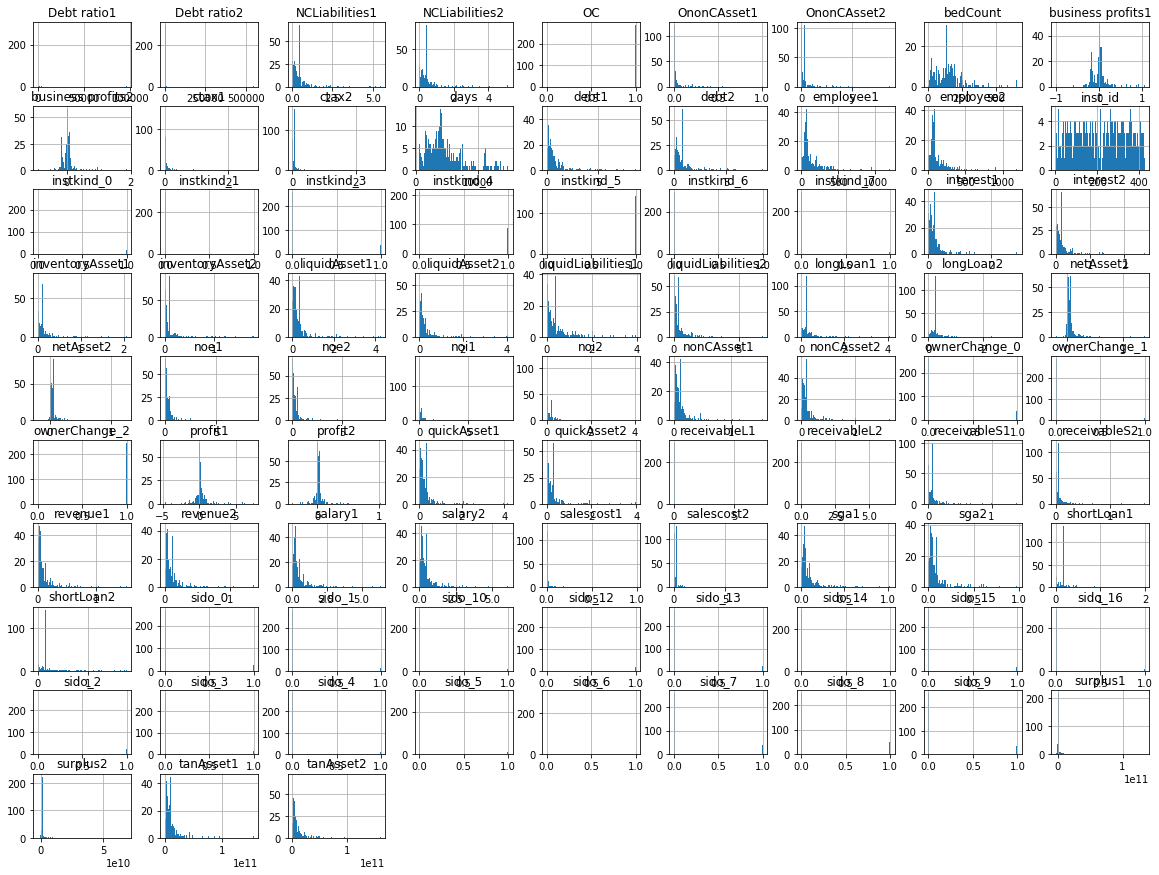

In [432]:
train2.hist(bins=100, figsize=(20,15))
plt.show()

In [433]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 84 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             296 non-null    int64  
 1   OC                  296 non-null    int64  
 2   bedCount            296 non-null    float64
 3   revenue1            296 non-null    float64
 4   salescost1          296 non-null    float64
 5   sga1                296 non-null    float64
 6   salary1             296 non-null    float64
 7   noi1                296 non-null    float64
 8   noe1                296 non-null    float64
 9   interest1           296 non-null    float64
 10  ctax1               296 non-null    float64
 11  profit1             296 non-null    float64
 12  liquidAsset1        296 non-null    float64
 13  quickAsset1         296 non-null    float64
 14  receivableS1        296 non-null    float64
 15  inventoryAsset1     296 non-null    float64
 16  nonCAsse

In [434]:
train2.tail()

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_5,sido_6,sido_7,sido_8,sido_9,sido_10,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_1,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
291,418,1,109.0,4.303270e+09,2.423876e+08,3.455912e+09,2.228914e+09,3840153.0,2.678230e+08,86869777.0,7.760281e+07,3.409870e+08,4.508958e+08,4.444234e+08,3.775848e+08,6472303.0,7.470236e+09,7.323860e+09,5.471640e+07,2.491294e+05,4.942362e+09,2.905427e+09,1.731667e+09,2.036935e+09,2.020000e+09,2.978770e+09,1.231924e+09,3.919676e+09,1.950452e+08,3.214299e+09,1.983768e+09,1173653.0,3.033400e+08,152320714.0,6.758503e+07,2.081659e+08,2.493244e+08,2.378112e+08,2.286310e+08,11513142.0,...,5.062574e+09,3.092828e+09,1.486493e+09,1.969747e+09,1.925500e+09,2.637783e+09,9.475288e+08,75.0,70.0,2485,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,6.049699e+08,5.103322e+08,114.851309,129.157973
292,419,1,367.0,1.207963e+10,5.309241e+08,9.521440e+09,5.691328e+09,49773739.0,1.151424e+09,202882821.0,4.468110e+08,4.788074e+08,3.424591e+09,3.366408e+09,2.508610e+09,58183039.0,1.421666e+10,1.409360e+10,1.055250e+08,2.491294e+05,8.097221e+09,6.926221e+09,1.731667e+09,1.170000e+09,2.603900e+09,9.544034e+09,1.231924e+09,1.086845e+10,5.650371e+08,8.828640e+09,5.327680e+09,59729148.0,4.978541e+08,190412606.0,6.758503e+07,1.036651e+09,3.312727e+09,3.280679e+09,1.781293e+09,32047864.0,...,7.191291e+09,1.101291e+09,2.813239e+08,6.090000e+09,5.890000e+09,9.065227e+09,9.475288e+08,180.0,180.0,2979,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2.027268e+09,1.474776e+09,67.032018,66.166646
293,420,1,136.5,5.500472e+09,1.963479e+09,4.883855e+09,2.653680e+09,62681034.0,3.831812e+08,53451647.0,5.042223e+07,2.456945e+08,3.772364e+09,3.757178e+09,1.031964e+09,15186803.0,5.289836e+09,5.287754e+09,3.348935e+08,2.491294e+05,4.478687e+09,9.577579e+08,1.731667e+09,3.520929e+09,1.800000e+09,4.583514e+09,1.231924e+09,5.555753e+09,1.809869e+09,4.936089e+09,2.618681e+09,66944448.0,3.884921e+08,54236956.0,5.147631e+07,2.466403e+08,2.997165e+09,2.980013e+09,7.571317e+08,17152386.0,...,3.945343e+09,7.113988e+08,1.486493e+09,3.233945e+09,1.800000e+09,4.337819e+09,9.475288e+08,62.0,66.0,2779,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.346862e+09,-1.190205e+09,81.423685,71.013654
294,422,1,214.0,7.614697e+09,4.153475e+08,5.903119e+09,3.467861e+09,42098974.0,7.439421e+08,187576102.0,7.760281e+07,5.943868e+08,2.776603e+09,2.769516e+09,1.797116e+09,7086391.0,1.191266e+10,1.171868e+10,1.198567e+08,2.491294e+05,8.715369e+09,1.520004e+09,1.731667e+09,7.195366e+09,5.930000e+09,5.973889e+09,1.406028e+09,7.068816e+09,4.057855e+08,6.755147e+09,3.768952e+09,90318167.0,2.090078e+08,196659822.0,5.160864e+07,-2.624151e+08,2.550562e+09,2.542336e+09,1.962693e+09,8225698.0,...,9.423771e+09,2.618201e+09,1.486493e+09,6.805570e+09,5.930000e+09,5.379502e+09,8.116416e+08,193.0,141.0,5071,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1.296230e+09,-9.211679e+07,114.454586,133.314706
295,427,0,180.0,2.116892e+09,2.681748e+08,3.286245e+09,2.231944e+09,123665065.0,5.366919e+08,514368798.0,7.760281e+07,-1.850554e+09,4.929370e+09,4.910840e+09,2.834734e+07,18529330.0,1.196624e+10,4.441451e+09,3.348935e+08,7.374231e+07,5.804268e+08,7.507060e+09,1.731667e+09,4.515262e+09,2.603900e+09,5.839519e+09,1.231924e+09,4.096872e+09,4.861985e+08,4.750651e+09,2.896997e+09,10545075.0,1.600243e+09,746156653.0,6.758503

### 2 - 9) $ log함수로 값 고르게 분포 시키기

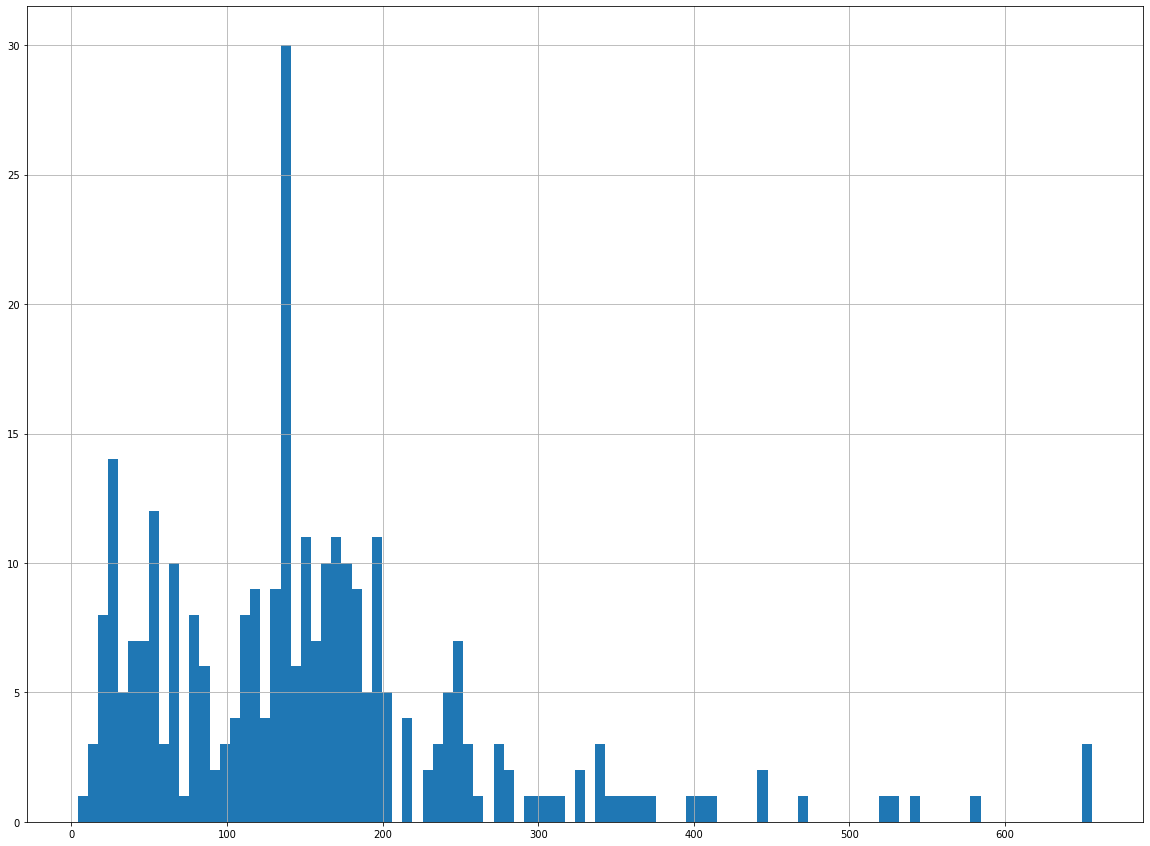

In [435]:
train2['bedCount'].hist(bins=100, figsize=(20,15))
plt.show()

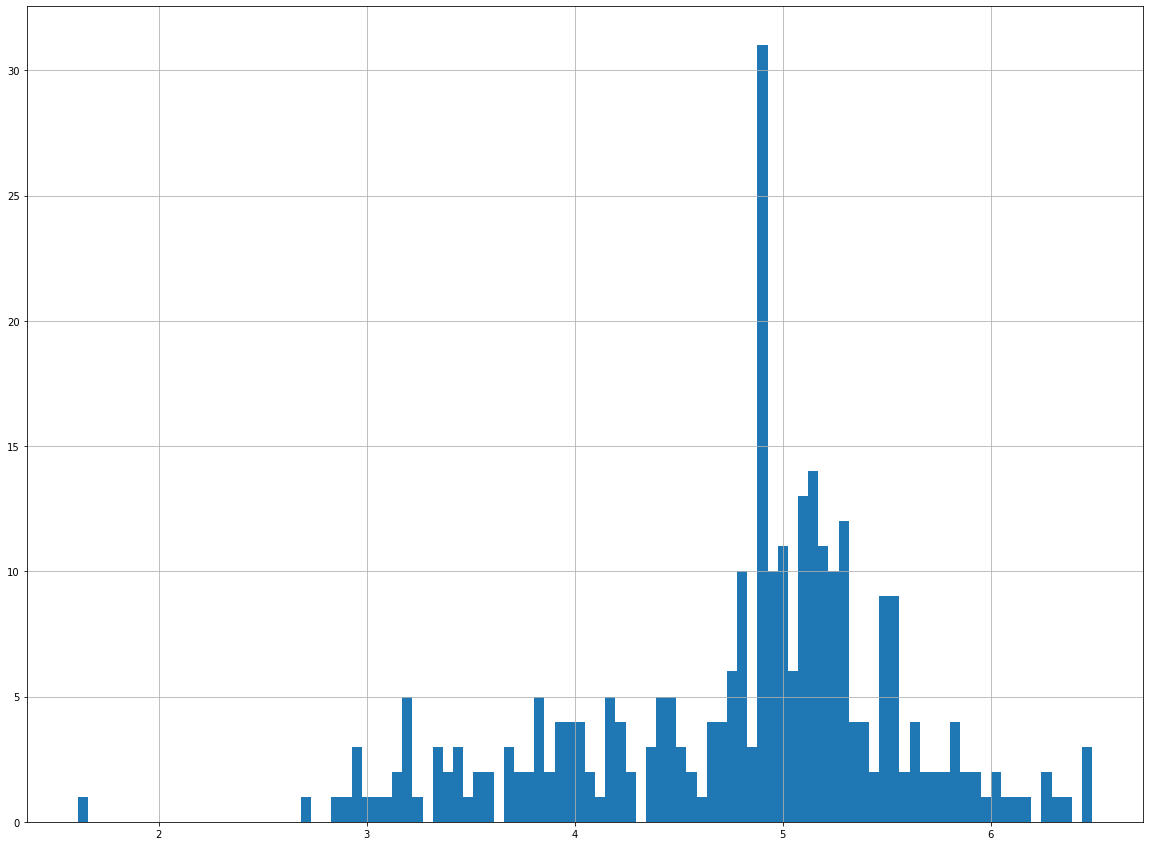

In [436]:
log_train2 = np.log1p(train2['bedCount'])
log_train2.hist(bins=100, figsize=(20,15))
plt.show()

In [437]:
box_train2 = stats.boxcox(train2['bedCount'])
box_train20 = pd.Series(box_train2[0])
box_train20

0      13.101424
1      18.151344
2      19.066246
3      17.161628
4      13.697437
         ...    
291    10.831246
292    17.414275
293    11.867498
294    14.174519
295    13.247580
Length: 296, dtype: float64

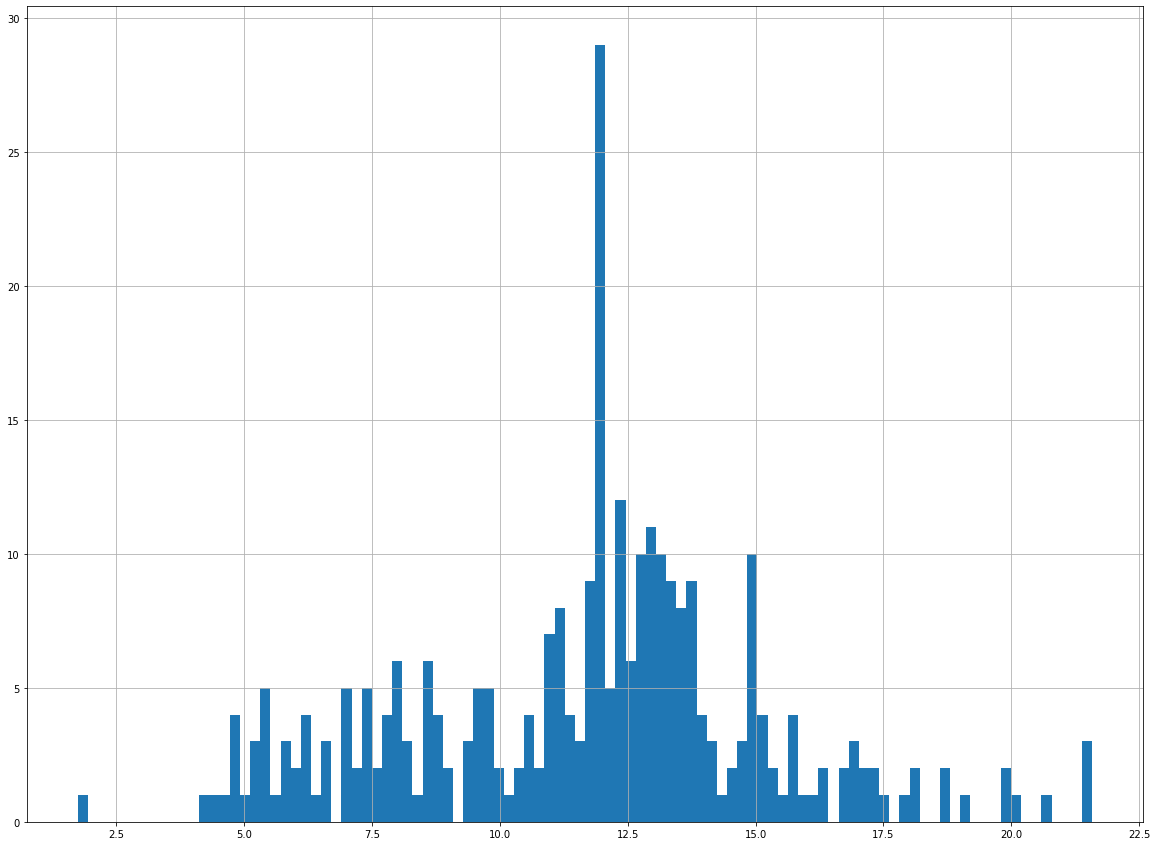

In [438]:
box_train20.hist(bins=100, figsize=(20,15))
plt.show()

In [439]:
train2['bedCount']

0      175.0
1      410.0
2      468.0
3      353.0
4      196.0
       ...  
291    109.0
292    367.0
293    136.5
294    214.0
295    180.0
Name: bedCount, Length: 296, dtype: float64

결과 => boxcox로 값을 분포시킨게 정규 분포가 가장 고르다!

In [440]:
stats.boxcox(train2['bedCount'],train2['revenue1'],train2['salescost1'])
stats.boxcox(train2['salary1'],train2['noi1'],train2['noe1'])
stats.boxcox(train2['interest1'],train2['ctax1'],train2['profit1'])
stats.boxcox(train2['liquidAsset1'],train2['quickAsset1'],train2['receivableS1'])
stats.boxcox(train2['inventoryAsset1'],train2['nonCAsset1'],train2['tanAsset1'])
stats.boxcox(train2['OnonCAsset1'],train2['receivableL1'],train2['debt1'])
stats.boxcox(train2['liquidLiabilities1'],train2['shortLoan1'],train2['NCLiabilities1'])
stats.boxcox(train2['longLoan1'],train2['netAsset1'],train2['surplus1'])
stats.boxcox(train2['revenue2'],train2['salescost2'],train2['sga2'])
stats.boxcox(train2['salary2'],train2['noi2'],train2['noe2'])
stats.boxcox(train2['interest2'],train2['ctax2'],train2['profit2'])
stats.boxcox(train2['liquidAsset2'],train2['quickAsset2'],train2['receivableS2'])
stats.boxcox(train2['inventoryAsset2'],train2['nonCAsset2'],train2['tanAsset2'])
stats.boxcox(train2['OnonCAsset2'],train2['receivableL2'],train2['debt2'])
stats.boxcox(train2['liquidLiabilities2'],train2['shortLoan2'],train2['NCLiabilities2'])
stats.boxcox(train2['longLoan2'],train2['netAsset2'],train2['surplus2'])
stats.boxcox(train2['employee1'],train2['employee2'],train2['days'])
stats.boxcox(train2['sga1'], train2['business profits1'], train2['business profits2'] )
stats.boxcox(train2['Debt ratio1'], train2['Debt ratio2'])

0       1.282994e+20
1      1.389620e+125
2       9.352332e+64
3       1.021167e+98
4      5.089492e+212
           ...      
291    9.372638e+263
292    1.043124e+119
293    6.887317e+133
294    2.095083e+272
295     1.756382e+21
Name: Debt ratio2, Length: 296, dtype: float64

In [441]:
box_train2 = stats.boxcox(train2['bedCount'])
train2['bedCount'] = pd.Series(box_train2[0])
train2['bedCount']

0      13.101424
1      18.151344
2      19.066246
3      17.161628
4      13.697437
         ...    
291    10.831246
292    17.414275
293    11.867498
294    14.174519
295    13.247580
Name: bedCount, Length: 296, dtype: float64

In [442]:
box_train2 = stats.boxcox(train2['revenue1'])
train2['revenue1'] = pd.Series(box_train2[0])
train2['revenue1']

0      62.949834
1      70.070410
2      54.602367
3      82.710033
4      79.712839
         ...    
291    63.074059
292    69.728207
293    64.605798
294    66.683565
295    58.816644
Name: revenue1, Length: 296, dtype: float64

In [443]:
box_train2 = stats.boxcox(train2['salescost1'])
train2['salescost1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['salary1'])
train2['salary1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['noi1'])
train2['noi1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['noe1'])
train2['noe1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['interest1'])
train2['interest1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['ctax1'])
train2['ctax1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['profit1'])     # = 음수값이 있어 박스코스로 분포시키가 어려워서 제거
#train2['profit1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['liquidAsset1'])
train2['liquidAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['quickAsset1'])
train2['quickAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['receivableS1'])
train2['receivableS1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['inventoryAsset1'])
train2['inventoryAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['nonCAsset1'])
train2['nonCAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['tanAsset1'])
train2['tanAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['OnonCAsset1'])
train2['OnonCAsset1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['receivableL1'])
#train2['receivableL1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['debt1'])
train2['debt1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['liquidLiabilities1'])
train2['liquidLiabilities1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['shortLoan1'])
train2['shortLoan1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['NCLiabilities1'])
train2['NCLiabilities1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['longLoan1'])
train2['longLoan1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['netAsset1'])
#train2['netAsset1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['surplus1'])
#train2['surplus1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['revenue2'])
train2['revenue2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['salescost2'])
train2['salescost2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['sga2'])
train2['sga2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['salary2'])
train2['salary2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['noi2'])
train2['noi2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['noe2'])
train2['noe2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['interest2'])
train2['interest2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['ctax2'])
train2['ctax2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['profit2'])
#train2['profit2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['liquidAsset2'])
train2['liquidAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['quickAsset2'])
train2['quickAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['receivableS2'])
train2['receivableS2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['inventoryAsset2'])
train2['inventoryAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['nonCAsset2'])
train2['nonCAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['tanAsset2'])
train2['tanAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['OnonCAsset2'])
train2['OnonCAsset2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['receivableL2'])
#train2['receivableL2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['debt2'])
train2['debt2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['liquidLiabilities2'])
train2['liquidLiabilities2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['shortLoan2'])
train2['shortLoan2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['NCLiabilities2'])
train2['NCLiabilities2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['longLoan2'])
train2['longLoan2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['netAsset2'])
#train2['netAsset2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['surplus2'])
#train2['surplus2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['employee1'])
#train2['employee1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['employee2'])
#train2['employee2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['days'])
train2['days'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['sga1'])
train2['sga1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['business profits1'])
#train2['business profits1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(train2['business profits2'])
#train2['business profits2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['Debt ratio1'])
train2['Debt ratio1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(train2['Debt ratio2'])
train2['Debt ratio2'] = pd.Series(box_train2[0])

In [444]:
train2

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_5,sido_6,sido_7,sido_8,sido_9,sido_10,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_1,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
0,1,1,13.101424,62.949834,36.807526,100.725027,15.791929,53.425822,73.435671,226.682849,175.580720,2.251697e+08,104.866071,103.827608,808.817700,36.109392,116.664117,89.164445,88.893054,2.491294e+05,112.899574,83.793121,976.967405,592.292056,143.832141,2.844460e+09,1.496394e+09,122.387746,37.274713,241.349426,56.718705,72.944232,72.319133,207.872066,117.329374,2.078297e+08,103.390348,104.034912,944.017364,37.748993,...,96.149408,128.466652,962.731832,885.868445,314.304816,2.619290e+09,1.271224e+09,62.0,64.0,21.756557,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.707083e+09,-1.569443e+09,2.561034,2.525262
1,3,1,18.151344,70.070410,36.807526,113.246426,16.313967,78.788473,128.951814,436.949536,213.081198,2.139033e+08,124.312797,122.672439,896.341952,45.098657,142.903897,106.603494,100.779698,2.491294e+05,163.286333,128.127019,976.967405,1040.389000,201.450916,5.839519e+09,1.231924e+09,139.728684,37.274713,277.398247,61.732063,110.749077,112.377180,368.668870,150.490859,2.552756e+08,124.523683,125.032964,980.583099,47.654708,...,132.080368,205.564846,962.731832,1578.068634,476.044613,5.182348e+09,9.475288e+08,801.0,813.0,25.730631,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,5.331689e+08,6.576224e+08,3.719469,3.513842
2,4,1,19.066246,54.602367,33.277111,76.558836,14.752073,24.037680,24.709192,436.949536,213.081198,4.186475e+07,87.310107,85.814752,267.725452,37.019345,76.593654,61.652227,100.779698,2.491294e+05,83.909366,75.033239,976.967405,1040.389000,201.450916,3.005088e+08,1.231924e+09,139.728684,37.274713,277.398247,61.732063,110.749077,112.377180,368.668870,150.490859,2.552756e+08,124.523683,125.032964,980.583099,47.654708,...,132.080368,205.564846,962.731832,1578.068634,476.044613,5.182348e+09,9.475288e+08,234.0,1.0,13.933526,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.181860e+07,6.576224e+08,2.075699,3.513842
3,7,1,17.161628,82.710033,36.807526,143.451230,17.175517,85.860594,148.988096,696.011007,253.385667,9.028303e+08,148.874678,145.094228,896.341952,59.021889,171.232601,124.575270,144.389166,2.491294e+05,205.191319,165.426037,1849.000562,1391.623427,238.983373,1.385710e+10,8.643659e+09,176.348060,37.274713,388.732293,73.107686,125.161496,128.267132,595.561598,188.805829,8.383875e+08,147.974177,147.046909,980.583099,62.297351,...,162.224249,262.903051,1555.424910,2412.004838,691.223318,1.295427e+10,7.740829e+09,663.0,663.0,24.695930,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-1.335340e+08,1.242746e+08,3.602891,3.373363
4,9,1,13.697437,79.712839,36.807526,136.744247,17.048560,70.122805,151.806550,711.392316,213.081198,8.074970e+07,134.884287,132.390161,1454.268783,52.046514,171.490033,126.392893,94.863972,2.491294e+05,210.047350,166.148937,1799.702946,1530.447013,264.976885,8.631164e+07,9.025550e+09,168.836407,37.274713,367.976805,71.511505,129.680267,130.507150,603.427613,150.490859,3.264258e+07,132.256852,131.779501,1584.484884,55.802675,...,168.972859,288.510021,1843.156024,2431.646317,681.207493,5.561941e+06,9.025550e+09,206.0,197.0,22.818230,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-5.759917e+08,-8.528666e+08,4.028570,3.802447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## profit1, receivableL1, netAsset1, surplus1, profit2, receivableL2, netAsset2, surplus2 => 음수값으로 인해 boxcox가 적용이 안돼서 log함수로 정규분포화

In [449]:
'''
np.log1p(train2['profit1'])
'''

"\nnp.log1p(train2['profit1'])\n"

In [450]:
'''
train2['profit1'] = np.log1p(train2['profit1'])
train2['receivableL1'] = np.log1p(train2['receivableL1'])
train2['netAsset1'] = np.log1p(train2['netAsset1'])
train2['surplus1'] = np.log1p(train2['surplus1'])
train2['receivableL2'] = np.log1p(train2['receivableL2'])
train2['netAsset2'] = np.log1p(train2['netAsset2'])
train2['surplus2'] = np.log1p(train2['surplus2'])
train2['employee1'] = np.log1p(train2['employee1'])
train2['employee2'] = np.log1p(train2['employee2'])
train2['business profits1'] = np.log1p(train2['business profits1'])
train2['business profits2'] = np.log1p(train2['business profits2'])
'''

"\ntrain2['profit1'] = np.log1p(train2['profit1'])\ntrain2['receivableL1'] = np.log1p(train2['receivableL1'])\ntrain2['netAsset1'] = np.log1p(train2['netAsset1'])\ntrain2['surplus1'] = np.log1p(train2['surplus1'])\ntrain2['receivableL2'] = np.log1p(train2['receivableL2'])\ntrain2['netAsset2'] = np.log1p(train2['netAsset2'])\ntrain2['surplus2'] = np.log1p(train2['surplus2'])\ntrain2['employee1'] = np.log1p(train2['employee1'])\ntrain2['employee2'] = np.log1p(train2['employee2'])\ntrain2['business profits1'] = np.log1p(train2['business profits1'])\ntrain2['business profits2'] = np.log1p(train2['business profits2'])\n"

In [452]:
train2.tail()

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_5,sido_6,sido_7,sido_8,sido_9,sido_10,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_1,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
291,418,1,10.831246,63.074059,31.380596,99.030242,15.839894,43.742993,116.638417,362.762651,213.081198,3.409870e+08,93.697450,92.809309,762.161230,32.805731,135.256646,102.249730,76.960209,2.491294e+05,150.660168,121.488113,976.967405,851.657242,193.073299,2.978770e+09,1.231924e+09,120.881243,31.358561,231.825362,56.500927,47.157110,102.699917,358.684249,150.490859,2.081659e+08,87.308183,87.413623,749.285578,37.020122,...,124.216768,198.761166,962.731832,1265.810801,443.779564,2.637783e+09,9.475288e+08,75.0,70.0,19.262772,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,6.049699e+08,5.103322e+08,4.119680,3.924358
292,419,1,17.414275,69.728207,33.352660,112.273132,16.323280,62.737993,146.899482,448.026248,310.186314,4.788074e+08,124.045437,122.712586,1273.242358,41.938713,147.525009,110.596194,84.918799,2.491294e+05,161.799018,136.837544,976.967405,740.744557,201.450916,9.544034e+09,1.231924e+09,138.580506,34.103884,275.985826,62.152278,90.048538,110.583852,378.335261,150.490859,1.036651e+09,125.288266,126.281639,1327.444467,41.680084,...,130.183273,167.604840,621.023740,1724.573762,564.591196,9.065227e+09,9.475288e+08,180.0,180.0,20.173675,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2.027268e+09,1.474776e+09,3.709678,3.482152
293,420,1,11.867498,64.605798,36.807526,103.378042,15.930877,64.755741,123.466907,321.394413,194.173199,2.456945e+08,125.701170,124.567743,1000.982355,36.152179,129.080642,98.315798,100.779698,2.491294e+05,148.526851,104.227123,976.967405,977.326126,189.381176,4.583514e+09,1.231924e+09,126.680375,37.274713,249.659247,58.044697,91.707246,106.568685,280.120101,142.752845,2.466403e+08,123.568710,124.610612,1046.099705,38.783669,...,120.135527,155.889483,962.731832,1450.033989,437.377085,4.337819e+09,9.475288e+08,62.0,66.0,19.820544,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.346862e+09,-1.190205e+09,3.859325,3.530180
294,422,1,14.174519,66.683565,32.727384,105.834861,16.069525,61.307564,137.130049,439.372232,213.081198,5.943868e+08,120.524930,119.479566,1163.285776,33.149995,144.052816,108.181795,86.546867,2.491294e+05,163.524879,111.111804,976.967405,1169.638762,231.103944,5.973889e+09,1.406028e+09,130.836285,33.234223,263.543807,60.121537,96.199630,97.122377,381.264133,142.823987,-2.624151e+08,120.843735,121.894783,1363.757768,35.581307,...,134.962169,193.380669,962.731832,1777.853261,565.413809,5.379502e+09,8.116416e+08,193.0,141.0,23.049146,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1.296230e+09,-9.211679e+07,4.117088,3.944637
295,427,0,13.247580,58.816644,31.630831,98.411600,15.840605,71.042153,130.234822,564.493172,213.081198,-1.850554e+09,130.389755,129.202460,376.994716,36.968148,144.139981,96.266931,100.779698,7.374231e+07,110.234286,138.349593,976.967405,1040.389000,201.450916,5.839519e+09,1.231924e+09,121.602245,33.707412,248.014349,58.614765,68.010291,131.474552,524.014048,150.490859,-2.729675e+09,135.638970,136.761226,404.905045,44.365085,...,93.924726,223.997480,962.731832,1578.068634,476.044613,5.182348e+09,9.475288e+08,100.0,76.5,22.228427,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,-1.437527e+09,-1.139978e+09,2.998595,2.429485


### 2 - 10) test데이터에 적용

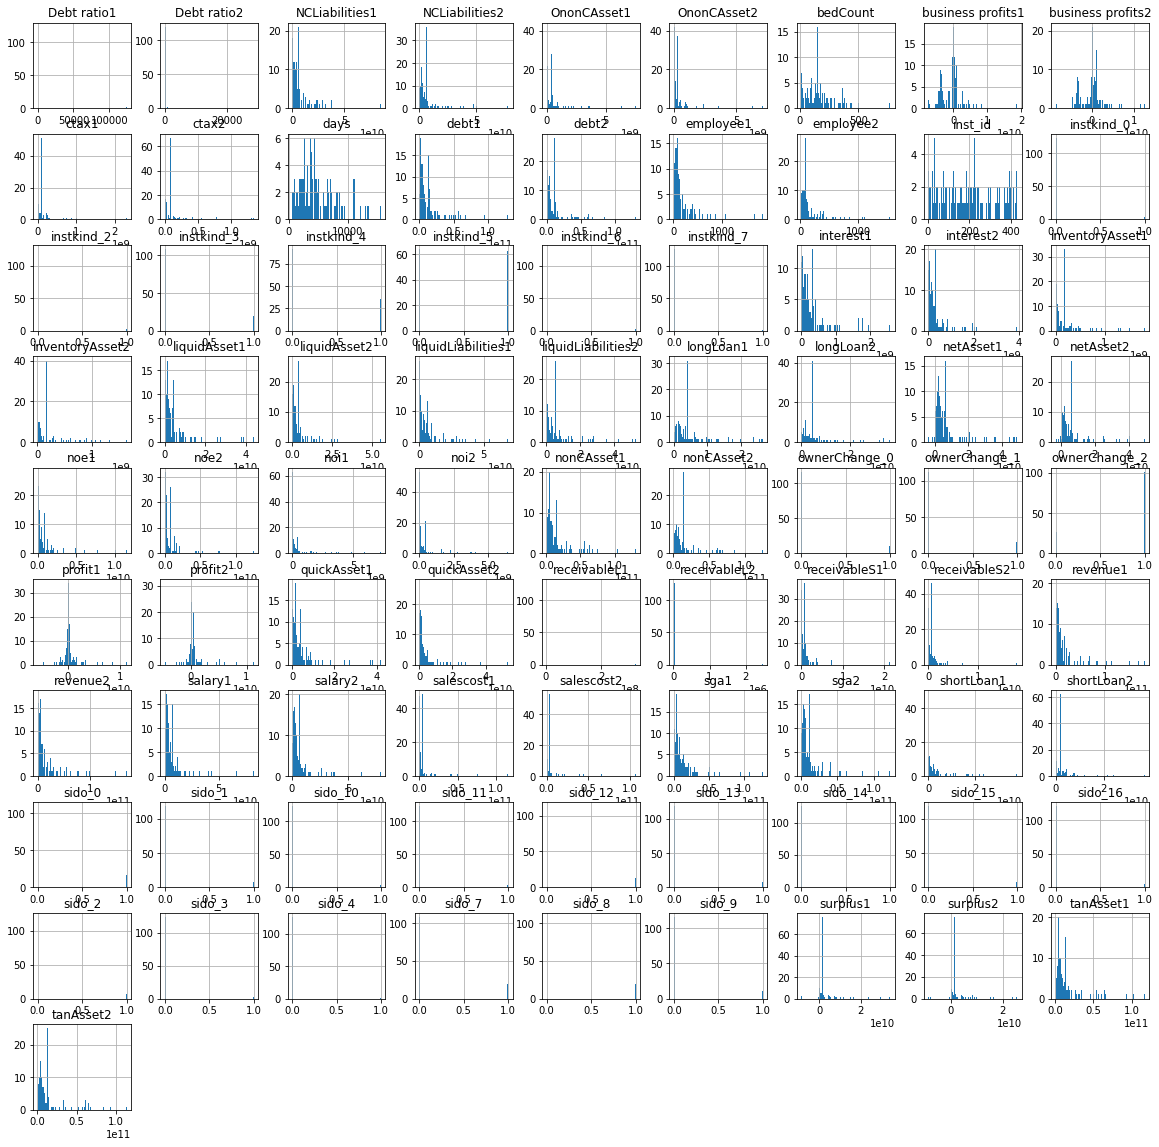

In [453]:
test2.hist(bins=100, figsize=(20,20))
plt.show()

In [454]:
stats.boxcox(test2['bedCount'],test2['revenue1'],test2['salescost1'])
stats.boxcox(test2['salary1'],test2['noi1'],test2['noe1'])
stats.boxcox(test2['interest1'],test2['ctax1'],test2['profit1'])
stats.boxcox(test2['liquidAsset1'],test2['quickAsset1'],test2['receivableS1'])
stats.boxcox(test2['inventoryAsset1'],test2['nonCAsset1'],test2['tanAsset1'])
stats.boxcox(test2['OnonCAsset1'],test2['receivableL1'],test2['debt1'])
stats.boxcox(test2['liquidLiabilities1'],test2['shortLoan1'],test2['NCLiabilities1'])
stats.boxcox(test2['longLoan1'],test2['netAsset1'],test2['surplus1'])
stats.boxcox(test2['revenue2'],test2['salescost2'],test2['sga2'])
stats.boxcox(test2['salary2'],test2['noi2'],test2['noe2'])
stats.boxcox(test2['interest2'],test2['ctax2'],test2['profit2'])
stats.boxcox(test2['liquidAsset2'],test2['quickAsset2'],test2['receivableS2'])
stats.boxcox(test2['inventoryAsset2'],test2['nonCAsset2'],test2['tanAsset2'])
stats.boxcox(test2['OnonCAsset2'],test2['receivableL2'],test2['debt2'])
stats.boxcox(test2['liquidLiabilities2'],test2['shortLoan2'],test2['NCLiabilities2'])
stats.boxcox(test2['longLoan2'],test2['netAsset2'],test2['surplus2'])
stats.boxcox(test2['employee1'],test2['employee2'],test2['days'])
stats.boxcox(test2['sga1'], test2['business profits1'], test2['business profits2'])
stats.boxcox(test2['Debt ratio1'], test2['Debt ratio2'])

0      5.899972e+172
1                inf
2       3.158418e+81
3      1.385994e+161
4      1.375244e+199
           ...      
122    2.114914e+127
123     6.294867e+15
124    1.466642e+174
125    2.618358e+146
126    5.505971e+215
Name: Debt ratio2, Length: 127, dtype: float64

In [455]:
box_train2 = stats.boxcox(test2['salescost1'])
test2['salescost1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['salary1'])
test2['salary1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['noi1'])
test2['noi1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['noe1'])
test2['noe1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['interest1'])
test2['interest1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['ctax1'])
test2['ctax1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['profit1'])     # = 음수값이 있어 박스코스로 분포시키가 어려워서 제거
#test2['profit1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['liquidAsset1'])
test2['liquidAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['quickAsset1'])
test2['quickAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['receivableS1'])
test2['receivableS1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['inventoryAsset1'])
test2['inventoryAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['nonCAsset1'])
test2['nonCAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['tanAsset1'])
test2['tanAsset1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['OnonCAsset1'])
test2['OnonCAsset1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['receivableL1'])
#test2['receivableL1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['debt1'])
test2['debt1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['liquidLiabilities1'])
test2['liquidLiabilities1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['shortLoan1'])
test2['shortLoan1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['NCLiabilities1'])
test2['NCLiabilities1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['longLoan1'])
test2['longLoan1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['netAsset1'])
#test2['netAsset1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['surplus1'])
#test2['surplus1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['revenue2'])
test2['revenue2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['salescost2'])
test2['salescost2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['sga2'])
test2['sga2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['salary2'])
test2['salary2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['noi2'])
test2['noi2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['noe2'])
test2['noe2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['interest2'])
test2['interest2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['ctax2'])
test2['ctax2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['profit2'])
#test2['profit2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['liquidAsset2'])
test2['liquidAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['quickAsset2'])
test2['quickAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['receivableS2'])
test2['receivableS2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['inventoryAsset2'])
test2['inventoryAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['nonCAsset2'])
test2['nonCAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['tanAsset2'])
test2['tanAsset2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['OnonCAsset2'])
test2['OnonCAsset2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['receivableL2'])
#test2['receivableL2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['debt2'])
test2['debt2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['liquidLiabilities2'])
test2['liquidLiabilities2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['shortLoan2'])
test2['shortLoan2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['NCLiabilities2'])
test2['NCLiabilities2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['longLoan2'])
test2['longLoan2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['netAsset2'])
#test2['netAsset2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['surplus2'])
#test2['surplus2'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['employee1'])
#test2['employee1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['employee2'])
#test2['employee2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['days'])
test2['days'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['sga1'])
test2['sga1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['business profits1'])
#test2['business profits1'] = pd.Series(box_train2[0])
#box_train2 = stats.boxcox(test2['business profits2'])
#test2['business profits2'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['Debt ratio1'])
test2['Debt ratio1'] = pd.Series(box_train2[0])
box_train2 = stats.boxcox(test2['Debt ratio2'])
test2['Debt ratio2'] = pd.Series(box_train2[0])

In [456]:
'''
test2['profit1'] = np.log1p(test2['profit1'])
test2['receivableL1'] = np.log1p(test2['receivableL1'])
test2['netAsset1'] = np.log1p(test2['netAsset1'])
test2['surplus1'] = np.log1p(test2['surplus1'])
test2['receivableL2'] = np.log1p(test2['receivableL2'])
test2['netAsset2'] = np.log1p(test2['netAsset2'])
test2['surplus2'] = np.log1p(test2['surplus2'])
test2['employee1'] = np.log1p(test2['employee1'])
test2['employee2'] = np.log1p(test2['employee2'])
test2['business profits1'] = np.log1p(test2['business profits1'])
test2['business profits2'] = np.log1p(test2['business profits2'])
'''

"\ntest2['profit1'] = np.log1p(test2['profit1'])\ntest2['receivableL1'] = np.log1p(test2['receivableL1'])\ntest2['netAsset1'] = np.log1p(test2['netAsset1'])\ntest2['surplus1'] = np.log1p(test2['surplus1'])\ntest2['receivableL2'] = np.log1p(test2['receivableL2'])\ntest2['netAsset2'] = np.log1p(test2['netAsset2'])\ntest2['surplus2'] = np.log1p(test2['surplus2'])\ntest2['employee1'] = np.log1p(test2['employee1'])\ntest2['employee2'] = np.log1p(test2['employee2'])\ntest2['business profits1'] = np.log1p(test2['business profits1'])\ntest2['business profits2'] = np.log1p(test2['business profits2'])\n"

In [457]:
test2

,inst_id,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_7,sido_8,sido_9,sido_10,sido_11,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_2,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
0,2,300.00,6.682486e+10,74.679712,1154.153398,50.822849,59.886938,107.963911,74.751442,79.666663,5.036692e+08,85.682026,80.139012,501.814701,343.419601,7.897429,7.833229,59.321149,2.583127e+06,238.780371,82.081045,158.868030,375.117299,333.805072,6.295769e+09,8.944587e+09,76.116958,75.740940,34.873100,45.477253,141.897274,74.464268,96.846637,269.708577,5.181821e+08,62.979537,35.848192,723.014418,310.002228,8.736598,...,19420.417323,144.445776,160.080666,253.597270,167.033974,156.167341,1.608540e+10,8.944587e+09,693.0,693.0,31.107067,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2.742976e+09,-2.592398e+09,3.802458,4.189100
1,5,44.00,3.495758e+10,74.679712,986.620818,48.367527,39.749694,96.235498,75.492153,84.390012,4.525557e+08,73.511208,68.875510,491.109966,272.256412,7.920132,7.851520,33.221976,2.583127e+06,238.036376,80.114910,148.973502,417.953377,402.006476,1.470447e+10,1.046277e+10,72.543390,75.740940,33.963264,44.018936,91.115796,73.205210,99.968692,217.322525,-4.645265e+09,55.132048,32.569487,429.746141,261.543070,8.761603,...,19420.417323,147.952430,156.287594,237.318529,214.811528,190.658898,3.789135e+09,1.622514e+09,379.0,371.0,17.836489,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.545870e+09,-4.727591e+09,4.210423,4.816317
2,6,276.00,2.326031e+10,71.281834,913.271001,47.064471,54.457093,91.899525,68.322097,84.390012,-2.148749e+09,79.607530,74.252973,865.840807,333.082045,7.871066,7.807351,49.366142,2.583127e+06,187.591336,77.117001,147.697911,329.542411,308.524066,6.625168e+09,1.638540e+10,69.802879,68.824642,33.052015,42.586115,93.940782,65.555464,85.831855,151.483073,-1.667198e+09,59.700014,34.514391,1113.696234,287.788711,8.701788,...,19420.417323,119.115460,148.097287,233.544823,174.847683,154.769406,6.019861e+09,1.638540e+10,100.0,85.0,34.565283,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,-2.369750e+09,-5.592507e+08,3.403173,3.650900
3,8,363.00,1.795715e+10,74.679712,805.600802,45.390595,60.557813,96.722183,61.155738,84.390012,2.789663e+09,76.536058,71.600039,522.111524,297.325118,7.914660,7.849551,55.429241,2.583127e+06,210.702492,76.500180,144.783946,282.198532,308.524066,4.702837e+10,1.954594e+09,67.218045,75.740940,31.784820,40.782312,146.000131,68.933886,78.516802,217.322525,2.862794e+09,59.090738,34.272837,622.042007,279.746569,8.723856,...,19420.417323,119.620763,128.900438,181.053071,152.272771,154.769406,3.914284e+10,1.622514e+09,760.0,760.0,24.799763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,8.533893e+08,9.039969e+08,4.106407,4.043869
4,10,213.00,5.037025e+10,74.679712,1078.769142,49.542803,54.230600,86.437563,77.972640,84.390012,3.346675e+09,75.775176,70.880693,321.593065,293.881460,7.912166,7.846454,70.077689,2.583127e+06,227.856727,76.209515,143.151027,418.032684,363.363366,2.268194e+10,1.492691e+10,73.525509,75.740940,34.057656,43.975842,126.208941,61.803217,108.950113,217.322525,4.614056e+09,57.504182,33.525334,444.301777,292.441026,8.756232,...,19420.417323,140.377484,124.958164,174.003517,226.950779,194.993407,2.574488e+10,1.507269e+10,437.0,385.0,28.488667,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2.098526e+09,-7.730316e+08,3.778305,4.319414
...,...,...,...,...,..

## 3. 모델 ( Logistic Regression )

### 3 - 1) 모델 변수 준비

In [458]:
test2

,inst_id,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,...,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_7,sido_8,sido_9,sido_10,sido_11,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_2,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
0,2,300.00,6.682486e+10,74.679712,1154.153398,50.822849,59.886938,107.963911,74.751442,79.666663,5.036692e+08,85.682026,80.139012,501.814701,343.419601,7.897429,7.833229,59.321149,2.583127e+06,238.780371,82.081045,158.868030,375.117299,333.805072,6.295769e+09,8.944587e+09,76.116958,75.740940,34.873100,45.477253,141.897274,74.464268,96.846637,269.708577,5.181821e+08,62.979537,35.848192,723.014418,310.002228,8.736598,...,19420.417323,144.445776,160.080666,253.597270,167.033974,156.167341,1.608540e+10,8.944587e+09,693.0,693.0,31.107067,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2.742976e+09,-2.592398e+09,3.802458,4.189100
1,5,44.00,3.495758e+10,74.679712,986.620818,48.367527,39.749694,96.235498,75.492153,84.390012,4.525557e+08,73.511208,68.875510,491.109966,272.256412,7.920132,7.851520,33.221976,2.583127e+06,238.036376,80.114910,148.973502,417.953377,402.006476,1.470447e+10,1.046277e+10,72.543390,75.740940,33.963264,44.018936,91.115796,73.205210,99.968692,217.322525,-4.645265e+09,55.132048,32.569487,429.746141,261.543070,8.761603,...,19420.417323,147.952430,156.287594,237.318529,214.811528,190.658898,3.789135e+09,1.622514e+09,379.0,371.0,17.836489,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-1.545870e+09,-4.727591e+09,4.210423,4.816317
2,6,276.00,2.326031e+10,71.281834,913.271001,47.064471,54.457093,91.899525,68.322097,84.390012,-2.148749e+09,79.607530,74.252973,865.840807,333.082045,7.871066,7.807351,49.366142,2.583127e+06,187.591336,77.117001,147.697911,329.542411,308.524066,6.625168e+09,1.638540e+10,69.802879,68.824642,33.052015,42.586115,93.940782,65.555464,85.831855,151.483073,-1.667198e+09,59.700014,34.514391,1113.696234,287.788711,8.701788,...,19420.417323,119.115460,148.097287,233.544823,174.847683,154.769406,6.019861e+09,1.638540e+10,100.0,85.0,34.565283,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,-2.369750e+09,-5.592507e+08,3.403173,3.650900
3,8,363.00,1.795715e+10,74.679712,805.600802,45.390595,60.557813,96.722183,61.155738,84.390012,2.789663e+09,76.536058,71.600039,522.111524,297.325118,7.914660,7.849551,55.429241,2.583127e+06,210.702492,76.500180,144.783946,282.198532,308.524066,4.702837e+10,1.954594e+09,67.218045,75.740940,31.784820,40.782312,146.000131,68.933886,78.516802,217.322525,2.862794e+09,59.090738,34.272837,622.042007,279.746569,8.723856,...,19420.417323,119.620763,128.900438,181.053071,152.272771,154.769406,3.914284e+10,1.622514e+09,760.0,760.0,24.799763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,8.533893e+08,9.039969e+08,4.106407,4.043869
4,10,213.00,5.037025e+10,74.679712,1078.769142,49.542803,54.230600,86.437563,77.972640,84.390012,3.346675e+09,75.775176,70.880693,321.593065,293.881460,7.912166,7.846454,70.077689,2.583127e+06,227.856727,76.209515,143.151027,418.032684,363.363366,2.268194e+10,1.492691e+10,73.525509,75.740940,34.057656,43.975842,126.208941,61.803217,108.950113,217.322525,4.614056e+09,57.504182,33.525334,444.301777,292.441026,8.756232,...,19420.417323,140.377484,124.958164,174.003517,226.950779,194.993407,2.574488e+10,1.507269e+10,437.0,385.0,28.488667,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2.098526e+09,-7.730316e+08,3.778305,4.319414
...,...,...,...,...,..

In [459]:
test3 = test2.drop(['sido_0','sido_1','sido_2','sido_3','sido_4','sido_7','sido_8','sido_9','sido_10','sido_11','sido_12','sido_13','sido_14','sido_15','sido_16','instkind_0','instkind_2','instkind_3','instkind_4','instkind_5','instkind_6','instkind_7','ownerChange_0','ownerChange_1','ownerChange_2'],axis = 1)
test3

,inst_id,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,business profits1,business profits2,Debt ratio1,Debt ratio2
0,2,300.00,6.682486e+10,74.679712,1154.153398,50.822849,59.886938,107.963911,74.751442,79.666663,5.036692e+08,85.682026,80.139012,501.814701,343.419601,7.897429,7.833229,59.321149,2.583127e+06,238.780371,82.081045,158.868030,375.117299,333.805072,6.295769e+09,8.944587e+09,76.116958,75.740940,34.873100,45.477253,141.897274,74.464268,96.846637,269.708577,5.181821e+08,62.979537,35.848192,723.014418,310.002228,8.736598,8.140028,78.426236,19420.417323,144.445776,160.080666,253.597270,167.033974,156.167341,1.608540e+10,8.944587e+09,693.0,693.0,31.107067,-2.742976e+09,-2.592398e+09,3.802458,4.189100
1,5,44.00,3.495758e+10,74.679712,986.620818,48.367527,39.749694,96.235498,75.492153,84.390012,4.525557e+08,73.511208,68.875510,491.109966,272.256412,7.920132,7.851520,33.221976,2.583127e+06,238.036376,80.114910,148.973502,417.953377,402.006476,1.470447e+10,1.046277e+10,72.543390,75.740940,33.963264,44.018936,91.115796,73.205210,99.968692,217.322525,-4.645265e+09,55.132048,32.569487,429.746141,261.543070,8.761603,8.163443,47.077561,19420.417323,147.952430,156.287594,237.318529,214.811528,190.658898,3.789135e+09,1.622514e+09,379.0,371.0,17.836489,-1.545870e+09,-4.727591e+09,4.210423,4.816317
2,6,276.00,2.326031e+10,71.281834,913.271001,47.064471,54.457093,91.899525,68.322097,84.390012,-2.148749e+09,79.607530,74.252973,865.840807,333.082045,7.871066,7.807351,49.366142,2.583127e+06,187.591336,77.117001,147.697911,329.542411,308.524066,6.625168e+09,1.638540e+10,69.802879,68.824642,33.052015,42.586115,93.940782,65.555464,85.831855,151.483073,-1.667198e+09,59.700014,34.514391,1113.696234,287.788711,8.701788,8.112830,72.629121,19420.417323,119.115460,148.097287,233.544823,174.847683,154.769406,6.019861e+09,1.638540e+10,100.0,85.0,34.565283,-2.369750e+09,-5.592507e+08,3.403173,3.650900
3,8,363.00,1.795715e+10,74.679712,805.600802,45.390595,60.557813,96.722183,61.155738,84.390012,2.789663e+09,76.536058,71.600039,522.111524,297.325118,7.914660,7.849551,55.429241,2.583127e+06,210.702492,76.500180,144.783946,282.198532,308.524066,4.702837e+10,1.954594e+09,67.218045,75.740940,31.784820,40.782312,146.000131,68.933886,78.516802,217.322525,2.862794e+09,59.090738,34.272837,622.042007,279.746569,8.723856,8.128709,70.705824,19420.417323,119.620763,128.900438,181.053071,152.272771,154.769406,3.914284e+10,1.622514e+09,760.0,760.0,24.799763,8.533893e+08,9.039969e+08,4.106407,4.043869
4,10,213.00,5.037025e+10,74.679712,1078.769142,49.542803,54.230600,86.437563,77.972640,84.390012,3.346675e+09,75.775176,70.880693,321.593065,293.881460,7.912166,7.846454,70.077689,2.583127e+06,227.856727,76.209515,143.151027,418.032684,363.363366,2.268194e+10,1.492691e+10,73.525509,75.740940,34.057656,43.975842,126.208941,61.803217,108.950113,217.322525,4.614056e+09,57.504182,33.525334,444.301777,292.441026,8.756232,8.158665,74.856577,19420.417323,140.377484,124.958164,174.003517,226.950779,194.993407,2.574488e+10,1.507269e+10,437.0,385.0,28.488667,-2.098526e+09,-7.730316e+08,3.778305,4.319414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,424,136.75,2.233031e+10,63.220423,868.958029,47.255311,47.799574,91.234697,63.281502,102.193142,1.692204e+09,82.681766,77.836785,738.378888,199.898626,7.823800,7.761547,53.97

In [460]:
train2

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,sido_0,sido_1,sido_2,sido_3,sido_4,sido_5,sido_6,sido_7,sido_8,sido_9,sido_10,sido_12,sido_13,sido_14,sido_15,sido_16,instkind_0,instkind_1,instkind_3,instkind_4,instkind_5,instkind_6,instkind_7,ownerChange_0,ownerChange_1,ownerChange_2,business profits1,business profits2,Debt ratio1,Debt ratio2
0,1,1,13.101424,62.949834,36.807526,100.725027,15.791929,53.425822,73.435671,226.682849,175.580720,2.251697e+08,104.866071,103.827608,808.817700,36.109392,116.664117,89.164445,88.893054,2.491294e+05,112.899574,83.793121,976.967405,592.292056,143.832141,2.844460e+09,1.496394e+09,122.387746,37.274713,241.349426,56.718705,72.944232,72.319133,207.872066,117.329374,2.078297e+08,103.390348,104.034912,944.017364,37.748993,...,96.149408,128.466652,962.731832,885.868445,314.304816,2.619290e+09,1.271224e+09,62.0,64.0,21.756557,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,-1.707083e+09,-1.569443e+09,2.561034,2.525262
1,3,1,18.151344,70.070410,36.807526,113.246426,16.313967,78.788473,128.951814,436.949536,213.081198,2.139033e+08,124.312797,122.672439,896.341952,45.098657,142.903897,106.603494,100.779698,2.491294e+05,163.286333,128.127019,976.967405,1040.389000,201.450916,5.839519e+09,1.231924e+09,139.728684,37.274713,277.398247,61.732063,110.749077,112.377180,368.668870,150.490859,2.552756e+08,124.523683,125.032964,980.583099,47.654708,...,132.080368,205.564846,962.731832,1578.068634,476.044613,5.182348e+09,9.475288e+08,801.0,813.0,25.730631,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,5.331689e+08,6.576224e+08,3.719469,3.513842
2,4,1,19.066246,54.602367,33.277111,76.558836,14.752073,24.037680,24.709192,436.949536,213.081198,4.186475e+07,87.310107,85.814752,267.725452,37.019345,76.593654,61.652227,100.779698,2.491294e+05,83.909366,75.033239,976.967405,1040.389000,201.450916,3.005088e+08,1.231924e+09,139.728684,37.274713,277.398247,61.732063,110.749077,112.377180,368.668870,150.490859,2.552756e+08,124.523683,125.032964,980.583099,47.654708,...,132.080368,205.564846,962.731832,1578.068634,476.044613,5.182348e+09,9.475288e+08,234.0,1.0,13.933526,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,4.181860e+07,6.576224e+08,2.075699,3.513842
3,7,1,17.161628,82.710033,36.807526,143.451230,17.175517,85.860594,148.988096,696.011007,253.385667,9.028303e+08,148.874678,145.094228,896.341952,59.021889,171.232601,124.575270,144.389166,2.491294e+05,205.191319,165.426037,1849.000562,1391.623427,238.983373,1.385710e+10,8.643659e+09,176.348060,37.274713,388.732293,73.107686,125.161496,128.267132,595.561598,188.805829,8.383875e+08,147.974177,147.046909,980.583099,62.297351,...,162.224249,262.903051,1555.424910,2412.004838,691.223318,1.295427e+10,7.740829e+09,663.0,663.0,24.695930,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-1.335340e+08,1.242746e+08,3.602891,3.373363
4,9,1,13.697437,79.712839,36.807526,136.744247,17.048560,70.122805,151.806550,711.392316,213.081198,8.074970e+07,134.884287,132.390161,1454.268783,52.046514,171.490033,126.392893,94.863972,2.491294e+05,210.047350,166.148937,1799.702946,1530.447013,264.976885,8.631164e+07,9.025550e+09,168.836407,37.274713,367.976805,71.511505,129.680267,130.507150,603.427613,150.490859,3.264258e+07,132.256852,131.779501,1584.484884,55.802675,...,168.972859,288.510021,1843.156024,2431.646317,681.207493,5.561941e+06,9.025550e+09,206.0,197.0,22.818230,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-5.759917e+08,-8.528666e+08,4.028570,3.802447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [461]:
train3 = train2.drop(['sido_0','sido_1','sido_2','sido_3','sido_4','sido_5','sido_6','sido_7','sido_8','sido_9','sido_10','sido_12','sido_13','sido_14','sido_15','sido_16','instkind_0','instkind_1','instkind_3','instkind_4','instkind_5','instkind_6','instkind_7','ownerChange_0','ownerChange_1','ownerChange_2'],axis = 1)
train3

,inst_id,OC,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,days,business profits1,business profits2,Debt ratio1,Debt ratio2
0,1,1,13.101424,62.949834,36.807526,100.725027,15.791929,53.425822,73.435671,226.682849,175.580720,2.251697e+08,104.866071,103.827608,808.817700,36.109392,116.664117,89.164445,88.893054,2.491294e+05,112.899574,83.793121,976.967405,592.292056,143.832141,2.844460e+09,1.496394e+09,122.387746,37.274713,241.349426,56.718705,72.944232,72.319133,207.872066,117.329374,2.078297e+08,103.390348,104.034912,944.017364,37.748993,84.862502,31.001881,98.886288,2.204132e+05,96.149408,128.466652,962.731832,885.868445,314.304816,2.619290e+09,1.271224e+09,62.0,64.0,21.756557,-1.707083e+09,-1.569443e+09,2.561034,2.525262
1,3,1,18.151344,70.070410,36.807526,113.246426,16.313967,78.788473,128.951814,436.949536,213.081198,2.139033e+08,124.312797,122.672439,896.341952,45.098657,142.903897,106.603494,100.779698,2.491294e+05,163.286333,128.127019,976.967405,1040.389000,201.450916,5.839519e+09,1.231924e+09,139.728684,37.274713,277.398247,61.732063,110.749077,112.377180,368.668870,150.490859,2.552756e+08,124.523683,125.032964,980.583099,47.654708,99.955037,33.800113,111.579011,2.204132e+05,132.080368,205.564846,962.731832,1578.068634,476.044613,5.182348e+09,9.475288e+08,801.0,813.0,25.730631,5.331689e+08,6.576224e+08,3.719469,3.513842
2,4,1,19.066246,54.602367,33.277111,76.558836,14.752073,24.037680,24.709192,436.949536,213.081198,4.186475e+07,87.310107,85.814752,267.725452,37.019345,76.593654,61.652227,100.779698,2.491294e+05,83.909366,75.033239,976.967405,1040.389000,201.450916,3.005088e+08,1.231924e+09,139.728684,37.274713,277.398247,61.732063,110.749077,112.377180,368.668870,150.490859,2.552756e+08,124.523683,125.032964,980.583099,47.654708,99.955037,33.800113,111.579011,2.204132e+05,132.080368,205.564846,962.731832,1578.068634,476.044613,5.182348e+09,9.475288e+08,234.0,1.0,13.933526,4.181860e+07,6.576224e+08,2.075699,3.513842
3,7,1,17.161628,82.710033,36.807526,143.451230,17.175517,85.860594,148.988096,696.011007,253.385667,9.028303e+08,148.874678,145.094228,896.341952,59.021889,171.232601,124.575270,144.389166,2.491294e+05,205.191319,165.426037,1849.000562,1391.623427,238.983373,1.385710e+10,8.643659e+09,176.348060,37.274713,388.732293,73.107686,125.161496,128.267132,595.561598,188.805829,8.383875e+08,147.974177,147.046909,980.583099,62.297351,116.834159,36.551011,163.747918,2.204132e+05,162.224249,262.903051,1555.424910,2412.004838,691.223318,1.295427e+10,7.740829e+09,663.0,663.0,24.695930,-1.335340e+08,1.242746e+08,3.602891,3.373363
4,9,1,13.697437,79.712839,36.807526,136.744247,17.048560,70.122805,151.806550,711.392316,213.081198,8.074970e+07,134.884287,132.390161,1454.268783,52.046514,171.490033,126.392893,94.863972,2.491294e+05,210.047350,166.148937,1799.702946,1530.447013,264.976885,8.631164e+07,9.025550e+09,168.836407,37.274713,367.976805,71.511505,129.680267,130.507150,603.427613,150.490859,3.264258e+07,132.256852,131.779501,1584.484884,55.802675,119.026460,37.134890,128.306977,2.204132e+05,168.972859,288.510021,1843.156024,2431.646317,681.207493,5.561941e+06,9.025550e+09,206.0,197.0,22.818230,-5.759917e+08,-8.528666e+08,4.028570,3.802447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,418,1,10.831246,63.074059,31.380596,99.030242,15.839894,43.742993,116.638417,362

### 3 - 2) 훈련데이터 x, y를 만듬

#### 훈련용 데이터

In [463]:
train3_x = train3.drop('OC', axis = 1)

In [464]:
train3_y = train3['OC']

In [465]:
train4_y = np.asarray(train3_y)
train4_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [492]:
train4_x = stats.zscore(train3_x)

In [493]:
train4_x

array([[-1.80080186,  0.40702989, -0.43172055, ..., -0.75599025,
        -1.7760681 , -1.69068132],
       [-1.78413794,  1.84947882,  0.50878227, ...,  0.17922452,
        -0.17117571, -0.10978465],
       [-1.77580597,  2.11080958, -1.53427412, ...,  0.17922452,
        -2.44844903, -0.10978465],
       ...,
       [ 1.69029076,  0.05457377, -0.21299686, ..., -0.59673635,
         0.022581  , -0.08365778],
       [ 1.70695468,  0.71354653,  0.06143956, ..., -0.13561458,
         0.37968413,  0.57912444],
       [ 1.7486145 ,  0.44877749, -0.97764225, ..., -0.57564436,
        -1.16987229, -1.84384397]])

테스트용 데이터


In [468]:
test3['OC'] = ''

In [486]:
test3_x = test3.drop('OC', axis = 1)
test4_x = stats.zscore(train3_x)
test4_x

296

In [504]:
test4_y = test3['OC']

### 3 - 3) 훈련

In [496]:
model = Sequential()
model.add( Dense( 1, input_dim = 57, activation = 'sigmoid' ) )   # 로지스틱은 시그모이드를 사용, 선형은 linear
sgd = optimizers.SGD( lr = 0.001 )
model.compile( optimizer = sgd, loss = 'binary_crossentropy',    # 로지스틱은 loss = 'binary_crossentropy', 선형은 loss = MSE
               metrics = ['binary_accuracy'] )
hist = model.fit(train4_x, train4_y, batch_size = 1, epochs = 200, shuffle = False )

Epoch 1/200
296/296 [==============================] - 0s 917us/step - loss: 0.7726 - binary_accuracy: 0.5236
Epoch 2/200
296/296 [==============================] - 0s 925us/step - loss: 0.6803 - binary_accuracy: 0.5811
Epoch 3/200
296/296 [==============================] - 0s 943us/step - loss: 0.6152 - binary_accuracy: 0.6622
Epoch 4/200
296/296 [==============================] - 0s 918us/step - loss: 0.5616 - binary_accuracy: 0.7466
Epoch 5/200
296/296 [==============================] - 0s 936us/step - loss: 0.5160 - binary_accuracy: 0.7939
Epoch 6/200
296/296 [==============================] - 0s 929us/step - loss: 0.4771 - binary_accuracy: 0.8378
Epoch 7/200
296/296 [==============================] - 0s 995us/step - loss: 0.4435 - binary_accuracy: 0.8750
Epoch 8/200
296/296 [==============================] - 0s 955us/step - loss: 0.4145 - binary_accuracy: 0.9088
Epoch 9/200
296/296 [==============================] - 0s 889us/step - loss: 0.3893 - binary_accuracy: 0.9257
Epoch 10/2

### 3 - 4) 모델 그래프

In [497]:
loss = hist.history[ 'loss' ]
epochs = range(1, len(loss)+1)

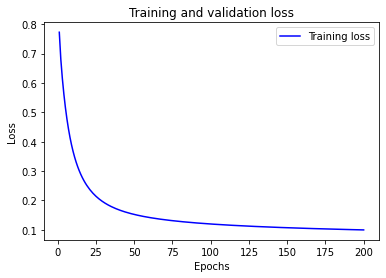

In [498]:
plt.plot( epochs, loss, 'b', label = 'Training loss' )
plt.title( 'Training and validation loss' )
plt.xlabel( 'Epochs' )
plt.ylabel( 'Loss' )
plt.legend()

plt.show()

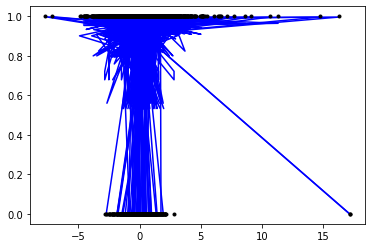

In [506]:
plt.plot( train4_x, model.predict( test4_x ), 'b', train4_x, train4_y, 'k.')

In [499]:
model.predict(test4_x)

array([[9.9301362e-01],
       [9.7959459e-01],
       [9.8545521e-01],
       [9.9311990e-01],
       [9.7742069e-01],
       [9.7085214e-01],
       [9.6769905e-01],
       [9.9655426e-01],
       [9.6442938e-01],
       [9.9186110e-01],
       [9.6909726e-01],
       [9.8289150e-01],
       [9.5944786e-01],
       [9.6984941e-01],
       [9.7476351e-01],
       [9.7635436e-01],
       [9.7769868e-01],
       [9.0878546e-01],
       [9.7351229e-01],
       [9.7969329e-01],
       [9.9404848e-01],
       [9.3645370e-01],
       [9.9008471e-01],
       [9.8588037e-01],
       [9.8790014e-01],
       [9.9213576e-01],
       [9.7938001e-01],
       [9.8917162e-01],
       [9.9602783e-01],
       [9.5324594e-01],
       [9.6834636e-01],
       [9.8692179e-01],
       [9.7558242e-01],
       [9.1333759e-01],
       [9.7963119e-01],
       [8.9032316e-01],
       [9.3394434e-01],
       [9.9151444e-01],
       [9.7450799e-01],
       [9.9038351e-01],
       [9.7258019e-01],
       [9.106279